# Pytorch Cheatsheet

* settings

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/0. codepool_python/python_dl/mybook/pytorch")

In [2]:
import numpy as np
import math
from collections import OrderedDict

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset

import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

from torchinfo import summary

## Tensors

### tensor 與四個重要 attribute

* 講到 tensor，就想到：
  * `tensor 是可以在指定 device (cpu / gpu) 上，進行 forward (一般 array 計算) 和 backward (求gradient) 計算的 numpy array`
* 所以，在建立 pytorch tensor 時，要注意以下四個 component:
  * `shape` (例如是 shape = (3,224,224) 的 img )
  * `dtype`: array 中每個 element 的 data type 是什麼？ e.g. float32, int32,...
  * `device`: 這個 tensor 即將在哪個 device 上做計算? (e.g. cpu? gpu?)
  * `requires_grad`: 這個 tensor 是否要記錄將來計算 gradient 會用到的訊息

* 看一下例子：

In [3]:
# Default datatype for tensors is float32
float_32_tensor = torch.tensor([3.0, 6.0, 9.0],
                               dtype=torch.float32, # defaults to None, which is torch.float32 or whatever datatype is passed
                               device=torch.device("cpu"), # defaults to None, which uses the default tensor type
                               requires_grad=True) # defaults to False. if True, operations performed on the tensor are recorded 

print(float_32_tensor)
print(float_32_tensor.shape) 
print(float_32_tensor.dtype)
print(float_32_tensor.device)

tensor([3., 6., 9.], requires_grad=True)
torch.Size([3])
torch.float32
cpu


* 新手在 pytorch & deep learning 的 coding 時最容易出現以下四種 error：
  * shape 錯誤 (e.g. 兩個 tensor 的 shape 無法相乘 )
  * dtype 錯誤 (e.g. 拿 float32 和 int32 的 tensor 做計算)
  * device 錯誤 (e.g. 兩個 tensor 所處的 device 不同)
  * gradient 沒有適時關閉/開啟，影響到 backward calculation

* 有關 shape 的錯誤，這牽扯矩陣計算的知識，所以這裡沒啥好補充的
* dtype, device, 和 gradient 的設定，是常常會遇到的，以下馬上做整理

#### data type

* 最常見(也是預設的) 就是 torch.float32，這邊會碰到 precision in computing 的概念，只要記得：  
  * float32: 是 single precision floating point，float32 是指 32 bit floating point (32 bit in memory)，也就是可以存 2^32 -1 個數字. 
  * float16 是 半精度，犧牲一點 precision，但加快計算速度

* 其他常見的 dtype，包括
  * torch.bool
  * torch.int8
  * torch.uint8
  * torch.int16
  * torch.int32
  * torch.int64
  * torch.half
  * torch.float32
  * torch.float16
  * torch.float64
  * torch.double

* 建立想要的 dtype 的 3 種方式:  
  * 用資料讓 pytorch 自行判斷 (給整數/小數 ...，如果給 3.0，那就會判定為 float32)
  * 建立 tensor 時，指定 dtype (e.g. `torch.tensor(1, dtype=torch.float32)`)
  * 轉換 dtype (e.g `int_tensor = torch.tensor(87); float_tensor = int_tensor.to(torch.float32)`)

In [6]:
# 直接給小數點

some_constants = torch.tensor([[3.1415926, 2.71828], [1.61803, 0.0072897]])
print(some_constants)

some_integers = torch.tensor((2, 3, 5, 7, 11, 13, 17, 19))
print(some_integers)

more_integers = torch.tensor(((2, 4, 6), [3, 6, 9]))
print(more_integers)


tensor([[3.1416, 2.7183],
        [1.6180, 0.0073]])
tensor([ 2,  3,  5,  7, 11, 13, 17, 19])
tensor([[2, 4, 6],
        [3, 6, 9]])


In [7]:
# 指定 type
a = torch.ones((2, 3), dtype=torch.int16)
print(a)

b = torch.rand((2, 3), dtype=torch.float64) * 20.
print(b)

tensor([[1, 1, 1],
        [1, 1, 1]], dtype=torch.int16)
tensor([[15.1821,  6.0043,  8.3599],
        [ 4.2249,  6.5844, 17.2819]], dtype=torch.float64)


In [14]:
# 轉換 type
c = b.to(torch.int32)
print(c)

tensor([[11, 11, 11],
        [18,  0, 18]], dtype=torch.int32)


#### device

* 設定 device

In [8]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

* 建立時直接指定 device

In [9]:
x = torch.rand(2, 2, device = device)
x

tensor([[0.0810, 0.1305],
        [0.0693, 0.4869]], device='cuda:0')

* 確認 目前變數的 device

In [10]:
x.device

device(type='cuda', index=0)

* 轉換 device

In [11]:
y1 = torch.rand(2, 2)
print(y1.device)

y2 = y1.to(device)
print(y2.device)

y3 = y2.to(torch.device("cpu"))
print(y3.device)

cpu
cuda:0
cpu


* tensor 做計算時，必須在同一個 device 上才能算 (都在 GPU or 都在 CPU)

In [12]:
x = torch.rand(2, 2)
y = torch.rand(2, 2, device='gpu')
z = x + y  # exception will be thrown

RuntimeError: Expected one of cpu, cuda, ipu, xpu, mkldnn, opengl, opencl, ideep, hip, ve, ort, mps, xla, lazy, vulkan, meta, hpu, privateuseone device type at start of device string: gpu

#### 關閉 gradient 計算

##### tensor_obj.detach()

* .detach() 的意思，主要就是刪掉 gradient 紀錄  
* 這主要是用在：
  * NN 計算到一半時，你想拿某個中間產物，出去算一些暫時的結果，然後再回來. 
  * 這時，你不希望中間跑出去算的哪些過程，也被記錄下來，導致去做 backpropagation 時，還會更新到那些 gradient，進而影想到真正的 variable 的 gradient

In [13]:
a = torch.rand(2, 2, requires_grad=True) # turn on autograd
print(a)

b = a.clone()
print(b)

c = a.detach().clone()
print(c)

print(a)

tensor([[0.7399, 0.9776],
        [0.9391, 0.1434]], requires_grad=True)
tensor([[0.7399, 0.9776],
        [0.9391, 0.1434]], grad_fn=<CloneBackward0>)
tensor([[0.7399, 0.9776],
        [0.9391, 0.1434]])
tensor([[0.7399, 0.9776],
        [0.9391, 0.1434]], requires_grad=True)


* 解釋一下這邊發生的事：  
  * 我們用 `requires_grad = True` 建立了 a ，所以去 print(a) 時，他告訴我們： requires_grad = True，表示 autograd 和 computation history tracking 都有被 turn on. 
  * 當我們單純把 a clone 到 b 時，他不僅繼承了 a 的 requires_grad，他也記錄了你的這次 computation history: clone，所以寫成 CloneBackward. 
  * 但如果我們先把 a detach，再把 a clone 給 c，就可以發現 c 乾乾淨淨的沒有任何 gradient 的痕跡。  
  * `detach()` 會 detaches the tensor from its computation history。他等於在說：不管接下來你要做啥計算，都把 autograd 給關起來。

##### with no_grad

* 在對 model 做 inference/evaluation 時，會關閉 gradient 的紀錄，這時就會用 context management，把 gradient 先關起來

### 100 種 建立 tensor 的方式

#### torch.empty(), torch.zeros(), torch.ones(), torch.rand()

In [14]:
# 建立出指定 shape 的 placeholder
x = torch.empty(3, 4)
print(x)

tensor([[ 1.5082e+03,  0.0000e+00,  1.5196e+03,  0.0000e+00],
        [-8.3862e+32,  4.5706e-41,  9.1084e-44,  0.0000e+00],
        [ 6.5767e-36,  0.0000e+00, -4.2653e-20,  4.5708e-41]])


* 這些數字都是假的，實際上只是在 memory 上幫你開好 (3, 4) 這種 shape 的 placeholder  

In [15]:
torch.zeros(2,3)

tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [16]:
torch.ones(2, 3)

tensor([[1., 1., 1.],
        [1., 1., 1.]])

In [17]:
torch.rand(2, 3) # 生出 0~1 的隨機數

tensor([[0.1293, 0.2467, 0.8110],
        [0.6600, 0.7898, 0.0111]])

#### torch.manual_seed()

In [18]:
torch.manual_seed(1729)
random1 = torch.rand(2, 3)
print(random1)

random2 = torch.rand(2, 3)
print(random2)

torch.manual_seed(1729)
random3 = torch.rand(2, 3)
print(random3)

random4 = torch.rand(2, 3)
print(random4)

tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691]])
tensor([[0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938]])
tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691]])
tensor([[0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938]])


* 設 seed 後，接續的第一、第二...、第 n 次生成，結果會不同，但只要再設一次 seed，那結果就會和之前的第一、第二、...、第 n 次相同

#### torch.empty_like(), torch.zeros_like(), torch.ones_like(), torch.rand_like()

In [19]:
x = torch.empty(2, 2, 3)
print(x.shape)
print(x)

empty_like_x = torch.empty_like(x)
print(empty_like_x.shape)
print(empty_like_x)

zeros_like_x = torch.zeros_like(x)
print(zeros_like_x.shape)
print(zeros_like_x)

ones_like_x = torch.ones_like(x)
print(ones_like_x.shape)
print(ones_like_x)

rand_like_x = torch.rand_like(x)
print(rand_like_x.shape)
print(rand_like_x)

torch.Size([2, 2, 3])
tensor([[[6.5738e-36, 0.0000e+00, 1.5085e+03],
         [0.0000e+00, 1.1210e-43, 0.0000e+00]],

        [[8.9683e-44, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.3881e+00]]])
torch.Size([2, 2, 3])
tensor([[[-4.2654e-20,  4.5708e-41, -4.2654e-20],
         [ 4.5708e-41,  4.4842e-44,  0.0000e+00]],

        [[ 1.1210e-43,  0.0000e+00,  1.5110e+03],
         [ 0.0000e+00,  1.4013e-45,  0.0000e+00]]])
torch.Size([2, 2, 3])
tensor([[[0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.]]])
torch.Size([2, 2, 3])
tensor([[[1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.]]])
torch.Size([2, 2, 3])
tensor([[[0.6128, 0.1519, 0.0453],
         [0.5035, 0.9978, 0.3884]],

        [[0.6929, 0.1703, 0.1384],
         [0.4759, 0.7481, 0.0361]]])


### tensor_obj.clone()

* tensor 是 mutable 的：

In [20]:
a = torch.ones(2, 2)
b = a

a[0][1] = 561  # we change a...
print(b)       # ...and b is also altered

tensor([[  1., 561.],
        [  1.,   1.]])


* 所以記得用 tensro_obj.clone() 來做 copy (就是 df.copy() 的類似寫法)

In [21]:
a = torch.ones(2, 2)
b = a.clone()

assert b is not a      # different objects in memory...
print(torch.eq(a, b))  # ...but still with the same contents!

a[0][1] = 561          # a changes...
print(b)               # ...but b is still all ones

tensor([[True, True],
        [True, True]])
tensor([[1., 1.],
        [1., 1.]])


### `torch.from_numpy(np_array)` and `tensor_obj.clone().numpy()`

* 把 numpy 改成 tensor 的目的：  
  * 可以放到 GPU 上加速  
  * 可以做 autograd. 
* 把 tensor 改成 numpy 的目的：  
  * 做些中途的計算 & 產出，但不會涉及到 gradient 紀錄. 
  * 特別小心，如果直接用 `tensor_obj.numpy()`，那他們是共享同個記憶體，是 mutable 的，所以改動 numpy 時，會影響到 tensor。所以才要先 clone() 再 numpy() (至於 detach 就不必要了，因為當你轉成 numpy 時，本來就不會有 gradient 紀錄了)

In [22]:
numpy_array = np.ones((2, 3))
print(numpy_array)

pytorch_tensor = torch.from_numpy(numpy_array)
print(pytorch_tensor)

[[1. 1. 1.]
 [1. 1. 1.]]
tensor([[1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)


* 直接做 `tensor_obj.numpy()`，那會是 mutable，改一個，影響另一個：

In [23]:
pytorch_rand = torch.rand(2, 3)
print(pytorch_rand)

numpy_rand = pytorch_rand.numpy()
print(numpy_rand)

tensor([[0.5062, 0.8469, 0.2588],
        [0.2707, 0.4115, 0.6839]])
[[0.5062225  0.84694576 0.25884217]
 [0.2706535  0.41147768 0.6838606 ]]


In [24]:
numpy_array[1, 1] = 23
print(pytorch_tensor)

pytorch_rand[1, 1] = 17
print(numpy_rand)

tensor([[ 1.,  1.,  1.],
        [ 1., 23.,  1.]], dtype=torch.float64)
[[ 0.5062225   0.84694576  0.25884217]
 [ 0.2706535  17.          0.6838606 ]]


* 但如果先 clone 再 .numpy，那就是不同記憶體了，彼此不影響：

In [25]:
pytorch_rand = torch.rand(2, 3)
print(pytorch_rand)

numpy_rand = pytorch_rand.clone().numpy()
print(numpy_rand)

tensor([[0.0703, 0.5105, 0.9451],
        [0.2359, 0.1979, 0.3327]])
[[0.07025403 0.5105133  0.9450517 ]
 [0.2358576  0.19793254 0.33274257]]


In [26]:
numpy_array[1, 1] = 23
print(pytorch_tensor)

pytorch_rand[1, 1] = 17
print(numpy_rand)

tensor([[ 1.,  1.,  1.],
        [ 1., 23.,  1.]], dtype=torch.float64)
[[0.07025403 0.5105133  0.9450517 ]
 [0.2358576  0.19793254 0.33274257]]


### reshape

* 介紹四種很常用的 reshape. 
  * `torch.reshape(input, shape)`
  * `torch.squeeze(input)` or/and `torch.unsqueeze(input, dim)`. 
  * `torch.permute(input, dims)`
  * `torch.stack(tensors, dim = 0)`

#### torch.reshape()

In [27]:
# Create a tensor
x = torch.arange(1., 9.)
x, x.shape

(tensor([1., 2., 3., 4., 5., 6., 7., 8.]), torch.Size([8]))

In [28]:
x.reshape((2,4))

tensor([[1., 2., 3., 4.],
        [5., 6., 7., 8.]])

#### unsqueeze (增軸) 與 squeeze (減軸)

* 我們常常想把單一一張 img 的 shape，增軸成 batch = 1 的一張 img (i.e. 把 shape = (3, 266, 266) 增軸成 (1, 3, 266, 266))
* 那 unsqueeze 就是增軸，例如這邊，我想增在 第 0 軸

In [29]:
a = torch.rand(3, 226, 226)
print(a.shape)

b = a.unsqueeze(dim = 0)
print(b.shape)

torch.Size([3, 226, 226])
torch.Size([1, 3, 226, 226])


* 相反的，我們有時候拿到帶有 batch 資訊的資料時，我們想把他 un-batch. 
* 例如，我拿到 shape = (1, 1) 的 output，但最前面的 1 其實是 batch_size，他就等於 1 而已. 
* 我想把他拔掉，就用 squeeze

In [30]:
a = torch.rand(1,1)
print(a)
print(a.shape)

b = a.squeeze(dim = 0)
print(b)
print(b.shape)

tensor([[0.9574]])
torch.Size([1, 1])
tensor([0.9574])
torch.Size([1])


In [31]:
a = torch.rand(1, 20)
print(a.shape)
print(a)

b = a.squeeze(0)
print(b.shape)
print(b)

torch.Size([1, 20])
tensor([[0.4265, 0.5256, 0.9091, 0.2780, 0.2162, 0.9831, 0.8699, 0.2427, 0.2078,
         0.7600, 0.9164, 0.7021, 0.0459, 0.6895, 0.2177, 0.6973, 0.8097, 0.9646,
         0.1726, 0.5225]])
torch.Size([20])
tensor([0.4265, 0.5256, 0.9091, 0.2780, 0.2162, 0.9831, 0.8699, 0.2427, 0.2078,
        0.7600, 0.9164, 0.7021, 0.0459, 0.6895, 0.2177, 0.6973, 0.8097, 0.9646,
        0.1726, 0.5225])


* pytorch 很聰明的，如果你的原始軸不是 1 ，他不會幫你 squeeze，例如下例就沒改變任何東西：

In [32]:
c = torch.rand(2, 2)
print(c)
print(c.shape)

d = c.squeeze(0)
print(d)
print(d.shape)

tensor([[0.8604, 0.8837],
        [0.8394, 0.8083]])
torch.Size([2, 2])
tensor([[0.8604, 0.8837],
        [0.8394, 0.8083]])
torch.Size([2, 2])


#### stack 組合 tensor (會增軸)

In [33]:
# 原始 tensor
x = torch.rand((3,224,224)) # img with shape (channel = 3, width = 224, height = 224)
y = torch.rand((3,224,224))

# 把兩張影像裝成一個 batch
batch = torch.stack([x, y], dim = 0)
print(batch.shape)

torch.Size([2, 3, 224, 224])


#### permute 換通道

In [34]:
x = torch.rand((3,224,224)) # img with shape (channel = 3, width = 224, height = 224)
y = x.permute(1, 2, 0) # 新的第0,1,2軸，分別選原本的第1,2,0軸
y.shape

torch.Size([224, 224, 3])

In [35]:
x = torch.rand((224,224,3)) # img with shape (width = 224, height = 224, channel = 3)
y = x.permute(2, 0, 1) # 新的第0,1,2軸，分別選原本的第2,0,1軸
y.shape

torch.Size([3, 224, 224])

### 對 tensor 的每個 element 做運算

#### 加, 減, 乘, 除, 開根號, 次方, ...

In [36]:
ones = torch.zeros(2, 2) + 1
twos = torch.ones(2, 2) * 2
threes = (torch.ones(2, 2) * 7 - 1) / 2
fours = twos ** 2 # 次方計算
sqrt2s = twos ** 0.5 # 開根號

print(ones)
print(twos)
print(threes)
print(fours)
print(sqrt2s)

tensor([[1., 1.],
        [1., 1.]])
tensor([[2., 2.],
        [2., 2.]])
tensor([[3., 3.],
        [3., 3.]])
tensor([[4., 4.],
        [4., 4.]])
tensor([[1.4142, 1.4142],
        [1.4142, 1.4142]])


#### 取絕對值, 取整數, 截斷, ...

In [37]:
# common functions
a = torch.rand(2, 4) * 2 - 1
print('Common functions:')
print(torch.abs(a))
print(torch.ceil(a))
print(torch.floor(a))
print(torch.clamp(a, -0.5, 0.5))

Common functions:
tensor([[0.8065, 0.5906, 0.6122, 0.4887],
        [0.1322, 0.7961, 0.6525, 0.7819]])
tensor([[-0., 1., -0., 1.],
        [-0., 1., 1., -0.]])
tensor([[-1.,  0., -1.,  0.],
        [-1.,  0.,  0., -1.]])
tensor([[-0.5000,  0.5000, -0.5000,  0.4887],
        [-0.1322,  0.5000,  0.5000, -0.5000]])


#### 三角函數 與 反函數

In [38]:
# trigonometric functions and their inverses
angles = torch.tensor([0, math.pi / 4, math.pi / 2, 3 * math.pi / 4])
sines = torch.sin(angles)
inverses = torch.asin(sines)
print('\nSine and arcsine:')
print(angles)
print(sines)
print(inverses)


Sine and arcsine:
tensor([0.0000, 0.7854, 1.5708, 2.3562])
tensor([0.0000, 0.7071, 1.0000, 0.7071])
tensor([0.0000, 0.7854, 1.5708, 0.7854])


In [39]:
# bitwise operations
print('\nBitwise XOR:')
b = torch.tensor([1, 5, 11])
c = torch.tensor([2, 7, 10])
print(torch.bitwise_xor(b, c))


Bitwise XOR:
tensor([3, 2, 1])


#### 比較兩 tensor 是否相等

In [40]:
# comparisons:
print('\nBroadcasted, element-wise equality comparison:')
d = torch.tensor([[1., 2.], [3., 4.]])
e = torch.ones(1, 2)  # many comparison ops support broadcasting!
print(torch.eq(d, e)) # returns a tensor of type bool


Broadcasted, element-wise equality comparison:
tensor([[ True, False],
        [False, False]])


### 對 tensor 做 summarise

#### 取最大最小值, 平均, 標準差...

In [41]:
# reductions:
print('\nReduction ops:')
print(torch.max(d))        # returns a single-element tensor
print(torch.max(d).item()) # extracts the value from the returned tensor
print(torch.mean(d))       # average
print(torch.std(d))        # standard deviation
print(torch.prod(d))       # product of all numbers
print(torch.unique(torch.tensor([1, 2, 1, 2, 1, 2]))) # filter unique elements


Reduction ops:
tensor(4.)
4.0
tensor(2.5000)
tensor(1.2910)
tensor(24.)
tensor([1, 2])


### matrix operation

* element-wise multiplication: `tensor1*tensor2`
* matrix multiplication `tensor.matmul(tensor1, tensor2)`

### 對 tensor 做 linear algebra

In [42]:
# vector and linear algebra operations
v1 = torch.tensor([1., 0., 0.])         # x unit vector
v2 = torch.tensor([0., 1., 0.])         # y unit vector
m1 = torch.rand(2, 2)                   # random matrix
m2 = torch.tensor([[3., 0.], [0., 3.]]) # three times identity matrix

print('\nVectors & Matrices:')
print(torch.cross(v2, v1)) # negative of z unit vector (v1 x v2 == -v2 x v1)
print(m1)
m3 = torch.matmul(m1, m2)
print(m3)                  # 3 times m1
print(torch.svd(m3))       # singular value decomposition


Vectors & Matrices:
tensor([ 0.,  0., -1.])
tensor([[0.3837, 0.1149],
        [0.0840, 0.8760]])
tensor([[1.1511, 0.3447],
        [0.2521, 2.6281]])
torch.return_types.svd(
U=tensor([[ 0.2028,  0.9792],
        [ 0.9792, -0.2028]]),
S=tensor([2.6867, 1.0936]),
V=tensor([[ 0.1788,  0.9839],
        [ 0.9839, -0.1788]]))


## 自動微分(model, loss_fn 和 optimizer 如何協作)

* 用 linear regression model 來舉例
  * 假設我們的 NN，超簡單，就是 input 有 5 個 neuron，output 為 1 個 neuron 的結構。(也就是 5 個變數的線性回歸)
  * 寫成數學式：
    * 只看一筆資料時： $\hat{y}_i = x_i^T W + b$, 其中，$x_i^T$ 是 1x5 的向量，W 是 5x1 的矩陣, (W 的 shape 是 (input, output), 所以，如果要 output 出 7 個 neuron, W 是 5x7 矩陣)
    * 看一個 batch 的資料時 (e.g. batch_size = 10): $\hat{y} = XW + b$, 其中，y是 10x1 的向量，X是 10x5 的矩陣，b會做 broad casting，所以變 10x1 的向量，但每個 element 的值都一樣
    * cost 是 mse，所以 cost function 是 $cost = \frac{1}{10} \sum_{i=1}^{10} \left( y_i - (x_i^TW + b) \right)^2 = \frac{1}{10} \sum_{i=1}^{10} \left( y_i - (x_{1i}w_1 + ... + x_{5i}w_5 + b) \right)^2$
    * 所以，做 gradient descent 時，就是要對 $w_i$ 和 $b$ 做偏微分，並用 $w_i^{new} = w_i^{old} - lr\times grad(w_i)$, $b^{new} = b^{old} - lr\times grad(b)$來更新參數。
    * 可以想像，每一次 iteration，我都要拿到 $W_{grad}$ 和 $b_{grad}$ 這兩個東西，且 shape 會和 $W$ 以及 $b$ 完全相同
* 用 pytorch 來解這個問題，如下：

In [43]:
# 真值
X = torch.rand(10,5)
W_true = torch.rand(5,1)
b_true = torch.rand(1)
y_true = torch.matmul(X,W_true)+b_true

print('W_true: \n', W_true, '\n')
print('b_true: \n', b_true, '\n')
print('y_true: \n', y_true, '\n')

W_true: 
 tensor([[0.1672],
        [0.7261],
        [0.8677],
        [0.1589],
        [0.6089]]) 

b_true: 
 tensor([0.2286]) 

y_true: 
 tensor([[1.9082],
        [1.3121],
        [1.5016],
        [1.1900],
        [1.6450],
        [1.6336],
        [2.1329],
        [1.1671],
        [1.6328],
        [1.7094]]) 



In [44]:
# model
model = torch.nn.Linear(5, 1)

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

# loss
mse_loss = torch.nn.MSELoss()

# W 參數估計的起始值
print('current estmated W: \n', model.weight.data, '\n')
print('current W_grad: \n', model.weight.grad, '\n')

# b 參數估計的起始值
print('current estmated b: \n', model.bias.data, '\n')
print('current b_grad: \n', model.bias.grad, '\n')

# 目前的預測值
y_pred = model(X)
print('current y_pred: \n', y_pred, '\n')

# 目前的 loss
loss = mse_loss(y_pred, y_true)
print('current loss: \n', loss)

current estmated W: 
 tensor([[-0.2711,  0.1681,  0.3631,  0.1607,  0.2658]]) 

current W_grad: 
 None 

current estmated b: 
 tensor([-0.1775]) 

current b_grad: 
 None 

current y_pred: 
 tensor([[ 0.3968],
        [-0.0029],
        [ 0.3377],
        [ 0.0565],
        [ 0.1576],
        [ 0.3519],
        [ 0.3798],
        [ 0.0702],
        [ 0.1862],
        [ 0.4231]], grad_fn=<AddmmBackward0>) 

current loss: 
 tensor(1.8532, grad_fn=<MseLossBackward0>)


* 因為資料進來了，所以可以做 backward，取得 W_grad 和 b_grad

In [45]:
# 先清空目前的 gradient
optimizer.zero_grad()

# 算 gradient
loss.backward()

# 看一下算出來的 W_grad 和 b_grad
print('current W_grad: \n', model.weight.grad, '\n')
print('current b_grad: \n', model.bias.grad, '\n')

# 更新 W 和 b
optimizer.step()

# 看一下新的 W 和 b
print('current estmated W: \n', model.weight.data, '\n')
print('current estmated b: \n', model.bias.data, '\n')

current W_grad: 
 tensor([[-0.9529, -1.7177, -1.5181, -1.1836, -1.3753]]) 

current b_grad: 
 tensor([-2.6952]) 

current estmated W: 
 tensor([[-0.2616,  0.1853,  0.3783,  0.1725,  0.2796]]) 

current estmated b: 
 tensor([-0.1506]) 



In [46]:
# 第二次的 forward，應該可以看到 loss 變小
y_pred = model(X)
print('current y_pred: \n', y_pred, '\n')
loss = mse_loss(y_pred, y_true)
print('current loss: \n', loss)

current y_pred: 
 tensor([[0.4669],
        [0.0512],
        [0.3960],
        [0.1120],
        [0.2224],
        [0.4154],
        [0.4516],
        [0.1181],
        [0.2523],
        [0.4823]], grad_fn=<AddmmBackward0>) 

current loss: 
 tensor(1.6898, grad_fn=<MseLossBackward0>)


In [47]:
# 第二次的 backward

# 可以看到，原本的 gradient 都還在，若不清空，gradient 會累加 (這不是我們要的)
print('current W_grad: \n', model.weight.grad, '\n')
print('current b_grad: \n', model.bias.grad, '\n')

# 所以才要這樣清空 gradient
optimizer.zero_grad()

# 看一下 gradient 被清空了
print('current W_grad: \n', model.weight.grad, '\n')
print('current b_grad: \n', model.bias.grad, '\n')

# 這時再來做 backward，算 gradient
loss.backward()

# 看一下算出來的 W_grad 和 b_grad
print('current W_grad: \n', model.weight.grad, '\n')
print('current b_grad: \n', model.bias.grad, '\n')

# 更新 W 和 b
optimizer.step()

# 看一下新的 W 和 b
print('current estmated W: \n', model.weight.data, '\n')
print('current estmated b: \n', model.bias.data, '\n')

current W_grad: 
 tensor([[-0.9529, -1.7177, -1.5181, -1.1836, -1.3753]]) 

current b_grad: 
 tensor([-2.6952]) 

current W_grad: 
 tensor([[0., 0., 0., 0., 0.]]) 

current b_grad: 
 tensor([0.]) 

current W_grad: 
 tensor([[-0.9107, -1.6405, -1.4495, -1.1284, -1.3128]]) 

current b_grad: 
 tensor([-2.5729]) 

current estmated W: 
 tensor([[-0.2439,  0.2171,  0.4064,  0.1945,  0.3051]]) 

current estmated b: 
 tensor([-0.1006]) 



In [48]:
# 第三次的 forward，應該可以看到 loss 變更小
y_pred = model(X)
print('current y_pred: \n', y_pred, '\n')
loss = mse_loss(y_pred, y_true)
print('current loss: \n', loss)

current y_pred: 
 tensor([[0.5971],
        [0.1515],
        [0.5041],
        [0.2151],
        [0.3425],
        [0.5333],
        [0.5848],
        [0.2070],
        [0.3749],
        [0.5921]], grad_fn=<AddmmBackward0>) 

current loss: 
 tensor(1.4068, grad_fn=<MseLossBackward0>)


* 以上，就是實際在跑 deep learning model 時，如何使用 loss, optimizer，來做到求 gradient 和更新參數～

## Data preparation

### Dataset - 自訂 class

In [49]:
class MyDataset(Dataset):
    def __init__(self, feature_matrix, label_vector):             # 把資料存進 class object
        self.feature_matrix = feature_matrix
        self.label_vector = label_vector
    def __len__(self):
        assert len(self.feature_matrix) == len(self.label_vector) # 確定資料有互相對應
        return len(self.feature_matrix)
    def __getitem__(self, idx):                     # 定義我們需要取得某筆資料的方式
        return self.feature_matrix[idx], self.label_vector[idx]

In [50]:
# 測試看看

X = np.random.rand(1000, 100, 100, 1)   # 虛構 1000 張 100 x 100 單色圖片
Y = np.random.randint(0, 7, [1000, 10]) # 虛構 1000 個 labels

my_dataset = MyDataset(X.astype(np.float32), Y.astype(np.float32))
taken_x, taken_y = my_dataset[0] # 取得第一筆資料
taken_x.shape, taken_y.shape

((100, 100, 1), (10,))

### Dataset - 直接用 `TensorDataset`

In [51]:
# 手上有的資料，先轉成 Tensor
X = np.random.rand(1000, 100, 100, 1)   # 虛構 1000 張 100 x 100 單色圖片
Y = np.random.randint(0, 7, [1000, 10]) # 虛構 1000 個 labels
tsrX, tsrY = torch.tensor(X), torch.tensor(Y)

# 餵到 TensorDataset 裡面
tsrdataset = TensorDataset(tsrX, tsrY)

In [52]:
# 幾個重要的用法
print(tsrdataset.__len__()) # 幾張圖
taken_x, taken_y = tsrdataset[0] # 取得第一筆資料
print(taken_x.shape, taken_y.shape)

1000
torch.Size([100, 100, 1]) torch.Size([10])


### DataLoader

In [53]:
# 將 dataset 包裝成 dataloader
my_dataloader = DataLoader(
    my_dataset, 
    batch_size=4,
    shuffle=True #, 
    # num_workers=4
)

# 跑一個 loop 確認拿到的 batch 是否正確
for batch_x, batch_y in my_dataloader:
    print((batch_x.shape, batch_y.shape))
    break

(torch.Size([4, 100, 100, 1]), torch.Size([4, 10]))


### 內建 dataset

#### 圖片類

##### 無 transform

In [55]:
# dataset
mnist_train = torchvision.datasets.FashionMNIST(
    root="/home/ubuntu/pytorch_dataset", train=True, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="/home/ubuntu/pytorch_dataset", train=False, download=True)

100.0%


Extracting /home/ubuntu/pytorch_dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to /home/ubuntu/pytorch_dataset/FashionMNIST/raw



100.0%


Extracting /home/ubuntu/pytorch_dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /home/ubuntu/pytorch_dataset/FashionMNIST/raw



100.0%


Extracting /home/ubuntu/pytorch_dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /home/ubuntu/pytorch_dataset/FashionMNIST/raw



100.0%

Extracting /home/ubuntu/pytorch_dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/ubuntu/pytorch_dataset/FashionMNIST/raw



* 此時為 dataset 格式

In [56]:
mnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /home/ubuntu/pytorch_dataset
    Split: Train

* 用 index 可以取資料

In [57]:
x, y = mnist_train[0] # 第 0 筆

* x 會是 PIL 物件, y 是 lab

In [58]:
type(x)

PIL.Image.Image

In [59]:
x

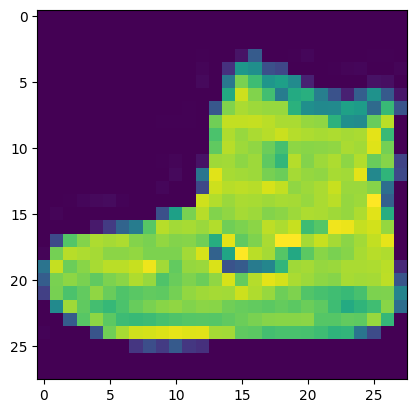

In [60]:
plt.imshow(x);

In [61]:
y

9

* 可以把 x 轉成 numpy 看看：

In [62]:
x_array = np.asarray(x)
print(x_array.shape)
print(x_array.dtype)
print(x_array.min())
print(x_array.max())

(28, 28)
uint8
0
255


* 可以看到是 28x28 的圖，且是 uint8 type，介於 0~255 整數值  

##### 有 transform

* 圖片類資料庫，通常都會做以下 transform:  
  * 把圖片改成 float32 浮點數 type. 
  * 把圖片正規化到 0~1 之間
  * 轉成 tensor (灰階圖，會變成 (1,28,28), RGB圖仍是 (3, 28, 28)) 
* 這其實就是 `torchvision.transforms.ToTensor()` 在做的事
* 看一下剛剛的例子

In [63]:
print(type(x))
print(np.asarray(x).dtype)

trans = torchvision.transforms.ToTensor()
x_trans = trans(x)
print(type(x_trans))
print(x_trans.dtype)
print(x_trans.min())
print(x_trans.max())

<class 'PIL.Image.Image'>
uint8
<class 'torch.Tensor'>
torch.float32
tensor(0.)
tensor(1.)


* 讀檔時，就可以把這個放進去：

In [64]:
trans = transforms.ToTensor()

mnist_train = torchvision.datasets.FashionMNIST(
    root="/home/ubuntu/pytorch_dataset", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="/home/ubuntu/pytorch_dataset", train=False, transform=trans, download=True)

In [65]:
mnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /home/ubuntu/pytorch_dataset
    Split: Train
    StandardTransform
Transform: ToTensor()

In [66]:
x, y = mnist_train[0]
print(x.shape)

torch.Size([1, 28, 28])


In [67]:
x.numpy().shape

(1, 28, 28)

## Transforms

* transforms 可以大致分為兩種：
  * 基本的影像前處理 (input 是 PIL 物件，output 也還是 PIL 物件)，例如：
    * `transforms.Resize(size)`:  input 是 PIL 物件，size 如果是 sequence (e.g. (h,w)), 那就是 resize 成 (h,w) 的大小。size 如果是 int (e.g. 224)，那他會幫你把短邊調到 224, 長邊就等比例縮小。  
    * `transforms.CenterCrop(size)`: input 是 PIL 物件，依據給定的 size 沿中心裁減，如果 size 是 int，就 crop 成 (size, size)，如果 size 是 (h, w)，就 crop 成 (h, w)   
    * `transforms.RandomCrop(size)`: input 是 PIL 物件，依據給定的 size，隨機沿一個中心裁減，size 定法同上). 
    * `transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.33), interpolation=2)`: 先隨機沿某個中心，將原影像剪裁為原圖 scale 倍的圖片 (以此例來說，就是剪成原圖 0.08 倍 ~ 1 倍),剪裁的長寬比，介於0.75~1.33 之間。剪完後，resize 成 size 大小的圖片，resize 方法預設是雙線性內插法 PIL.Image.BILINEAR   
    * `transforms.RandomHorizontalFlip(p=0.5)`: 隨機上下翻轉
    * `transforms.RandomVerticalFlip(p=0.5)`: 隨機左右翻轉
    * `transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))`: 就 gaussianBlur
    * `transforms.Grayscale()`: input 是 PIL 物件，幫你轉成灰階. 
  * 餵進 model 時的數值處理，例如：
    * `transforms.ToTensor()`: input 是 PIL 或 numpy，output是 0 到 1 tensor.float, 且通道在前。(如果 numpy 的 type 是 uint8，那 range 是 0 到 255, 他就會幫你 scaling 到 0~1; 如果 numpy 的 type 就已經是 float，他就不會再幫你 scaling). 
    * `transforms.Normalize()`: input 是 tensor, 假設 k 個通道，那你就要給他 k 維的 mean list 和 sd list，他就幫你對每一個通道做 normalization。如果是用 imagenet pretrained model，他根據資料庫所有影像已幫你算好各通道的平均數和邊準差，分別是： `mean=[0.485, 0.456, 0.406]`, `std=[0.229, 0.224, 0.225]`
* 官網的範例可以看這：https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py 
* 官網的詳細文件看這：https://pytorch.org/vision/stable/transforms.html  
* 以下列出基本套路，再個別實驗來看看效果

In [4]:
# 用 imagenet pre-trained model 需做的 preprocess
imagenet_transform = transforms.Compose([
    # pre-processing
    transforms.Resize((224, 224)),
    # to tensor & normalization
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# training 時常用的 augmentation
training_transform = transforms.Compose([
    # pre-processing
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # to tensor
    transforms.ToTensor()
])

# testing/inference 時用的，就基本的
training_transform = transforms.Compose([
    # pre-processing
    transforms.Resize((224, 224)),
    # to tensor
    transforms.ToTensor()
])

## activation functions

### 內建

| activation function | `torch.nn as nn`                    | `torch.nn.functional as F` |
|:-------------------:| ----------------------------------- | -------------------------- |
| Sigmoid             | `nn.Sigmoid()`                      | `F.sigmoid`                |
| Softmax             | `nn.Softmax(dim=None)`              | `F.softmax`                |
| ReLU                | `nn.ReLU()`                         | `F.relu`                   |
| LeakyReLU           | `nn.LeakyReLU(negative_slope=0.01)` | `F.leaky_relu`             |
| Tanh                | `nn.Tanh()`                         | `F.tanh`                   |
| GELU                | `nn.GELU()`                         | `F.gelu`                   |
| ReLU6               | `nn.ReLU6()`                        | `F.relu6`                  |

#### ReLU

* 主要重點：  
  * $ReLU(x) = max(x, 0)$  
  * $\frac{x}{dx} ReLU(x) = 1$ if x > 0; $\frac{x}{dx} ReLU(x) = 0$ if x <= 0
  * relu 的導數，在 x = 0 時，數學上是不存在，但在工程上 "定義" 導數為 0，這樣就能繼續做了  
  * relu 的優點是求導的結果簡單，不是 0 就是 1，在 backward 更新參數時， `weight_new = weight_old - learning_rate * grad`，那 grad 不是 0 就是 1，減輕了以往NN的梯度消失問題。  
* 簡單範例：

In [69]:
activation = nn.ReLU()

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = activation(x)
print(y)

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

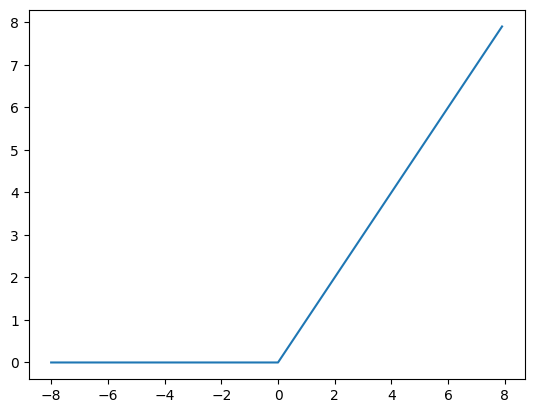

In [70]:
plt.plot(x.detach(), y.detach());

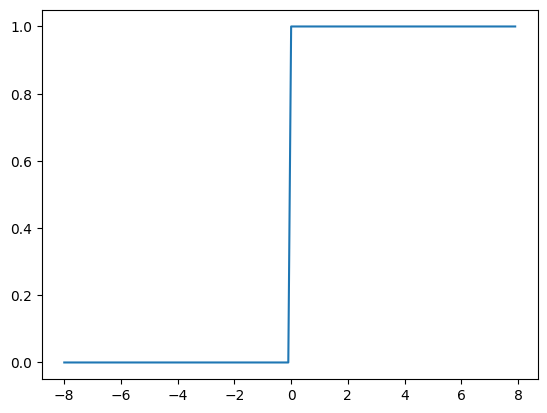

In [71]:
y.backward(torch.ones_like(x), retain_graph=True)
plt.plot(x.detach(), x.grad); # gradient

#### Sigmoid

* 主要重點：  
  * $sigmoid(x) = \frac{1}{1 + exp(-x)}$  
  * $\frac{x}{dx} sigmoid(x) = sigmoid(x)(1-sigmoid(x))$  
  * 從導數的性質，可以發現，gradient 在 x 靠近 0 時，值較大 (參數更新較快）， x 遠離 0 時， gradient 趨近於 0 (參數停止更新)

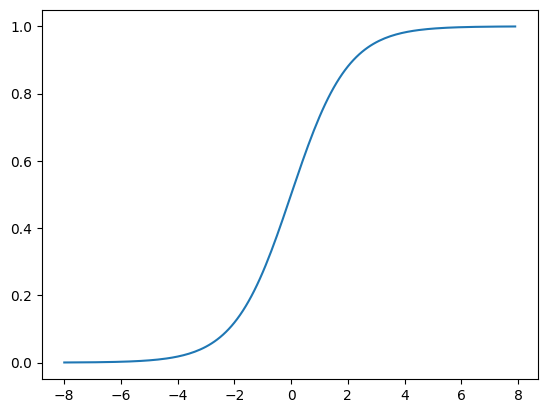

In [72]:
activation = nn.Sigmoid()

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = activation(x)

plt.plot(x.detach(), y.detach());

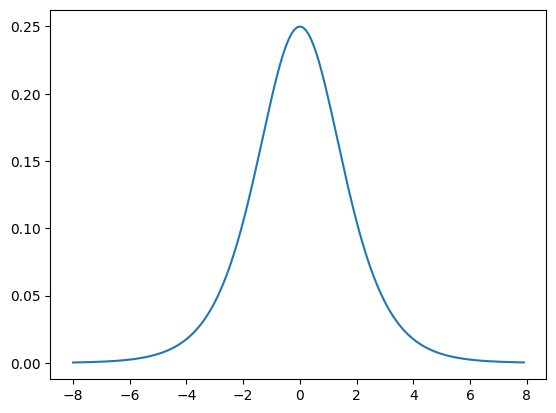

In [73]:
# gradients
y.backward(torch.ones_like(x),retain_graph=True)
plt.plot(x.detach(), x.grad);

### 自訂

* 直接定義一個 function

In [75]:
def relu(x):
    a = torch.zeros_like(x) # shape 會與 x 一樣
    return torch.max(x, a)

## custom layers & block

<img src="imgs/layer_block_model.jpg" width=600 alt="layer_block_model"/>

* 幾個名詞定義一下：  
  * layer: 只要是 input n 個 neruon, output m 個 neuron 的 function，就被稱為一個 layer。例如 `nn.Linear(in_dim, out_dim)` 就是個 linear layer. 
  * block: 
    * 多個 layer 組合在一起，稱為一個 block。例如一個 VGG block，就是由數個 conv, pooling layer 所組成. 
    * 通常用 sequential 來把 layer 組成 block; 或用 sub-class 來把 layer 組成 block
  * model: 
    * 由 layers or/and blocks 組起來，只要 input 是 feature/images/sentences..，output 是 回歸/分類...結果，就都可稱為 model。
    * 例如一個 linear layer 可以是 model (e.g. linear regression)，一個 block 可以是 model (e.g. 多層感知機)，多個 block 組在一起 (e.g. resnet) 也可以是 model  
    * 所以，可以用 `layer` 來做出 model，也可以用 `sequential` 組成 model，也可以用 `sub-class` 組成 model

### custom layer (不帶參數)

In [78]:
class CenteredLayer(nn.Module):
    """用來做中心化(去平均)的layer
    args:
      X: 任何 shape，但通常是 (n, p)，然後我們想把 feature 都 de-mean
    """
    def __init__(self, dim = 0):
        super().__init__()
        self.dim = dim

    def forward(self, X):
        return X - X.mean(dim = self.dim, keepdim = True)

In [79]:
# 做 5 個 sample，每個 sample 都有 2 個 feature 的 X
X = torch.randn(5, 2)
X

tensor([[-1.1121,  1.7709],
        [-1.0068, -1.2362],
        [ 0.0348,  1.1227],
        [-0.2837, -1.2738],
        [ 1.2561, -0.0931]])

In [80]:
layer = CenteredLayer()
layer(X)

tensor([[-0.8898,  1.7128],
        [-0.7844, -1.2943],
        [ 0.2571,  1.0646],
        [-0.0613, -1.3318],
        [ 1.4784, -0.1512]])

* 可以清楚看到，de-mean 後，每個 col 現在相加都是 0

* 之後，這種 layer 就可以當作前處理，然後這樣用：

In [81]:
model = nn.Sequential(
    CenteredLayer(), # 前處理用，de-mean
    nn.Linear(2, 1) # linear regression
)
model(X)

tensor([[-0.6427],
        [-0.0380],
        [-0.6522],
        [-0.1202],
        [-0.5543]], grad_fn=<AddmmBackward0>)

### custom layer (帶參數)

* 重點在，weight, bias 要用 `nn.Parameter()` 來造，這樣就可以保有計算 gradient 等功能(預設 requires_grad = True) 

In [82]:
? nn.Parameter

Init signature:  nn.Parameter(data=None, requires_grad=True)
Docstring:     
A kind of Tensor that is to be considered a module parameter.

Parameters are :class:`~torch.Tensor` subclasses, that have a
very special property when used with :class:`Module` s - when they're
assigned as Module attributes they are automatically added to the list of
its parameters, and will appear e.g. in :meth:`~Module.parameters` iterator.
Assigning a Tensor doesn't have such effect. This is because one might
want to cache some temporary state, like last hidden state of the RNN, in
the model. If there was no such class as :class:`Parameter`, these
temporaries would get registered too.

Args:
    data (Tensor): parameter tensor.
    requires_grad (bool, optional): if the parameter requires gradient. See
        :ref:`locally-disable-grad-doc` for more details. Default: `True`
File:           ~/miniconda3/envs/py39/lib/python3.9/site-packages/torch/nn/parameter.py
Type:           _ParameterMeta
Subclasses:  

In [83]:
class MyLinear(nn.Module):
    """ 自己寫一個 dense 層 """
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_dim, out_dim))
        self.bias = nn.Parameter(torch.randn(out_dim,))
    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return linear

* 看一下實例化後，起始參數：

In [84]:
linear = MyLinear(5, 3)
linear.weight

Parameter containing:
tensor([[ 0.8718,  0.9469,  0.1916],
        [ 1.6973,  1.5636, -0.3113],
        [ 0.7594, -1.1440, -1.7244],
        [-0.7467,  0.9555,  0.9014],
        [-0.5161,  0.7031, -1.6652]], requires_grad=True)

* 用用看：

In [85]:
X = torch.randn(10, 5)
linear(X)

tensor([[ 4.2076,  1.0059, -5.5664],
        [ 2.2081,  3.5985, -4.8784],
        [ 1.4460,  2.0264,  0.4752],
        [-0.4749, -1.9205, -2.2298],
        [ 1.1014, -0.4691, -3.6861],
        [-2.3040,  1.4275, -0.5245],
        [ 1.8266,  1.2462, -3.5570],
        [ 1.2729,  2.0576, -4.6761],
        [-1.4266, -0.1284, -0.0855],
        [ 0.2521, -1.2549,  1.0474]])

### sequential block (`nn.Sequential(layer1, block2, ...)`)

In [86]:
net = nn.Sequential(
    nn.Linear(20, 256), 
    nn.ReLU(), 
    nn.Linear(256, 10)
)

X = torch.rand(2, 20)
net(X)

tensor([[-0.1119,  0.0200,  0.2404,  0.2004, -0.0767, -0.1386,  0.1669, -0.1070,
          0.0494, -0.1204],
        [-0.1727,  0.0096,  0.1246,  0.2796, -0.0674, -0.1257,  0.0676,  0.0165,
          0.1145, -0.0782]], grad_fn=<AddmmBackward0>)

### sequential `for` tips

* 我們可以建立一個自己的 sequential，就可以看到實際運作狀況：

In [87]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            # args 就是 user 隨意要丟幾個 layer, block 進來，所組成的 list
            # 变量_modules中。_module的类型是OrderedDict
            self._modules[str(idx)] = module

    def forward(self, X):
        # OrderedDict保证了按照成员添加的顺序遍历它们
        for block in self._modules.values():
            X = block(X)
        return X

* 來試試看：

In [88]:
net = MySequential(
    nn.Linear(20, 256), 
    nn.ReLU(), 
    nn.Linear(256, 10)
)

net(X)

tensor([[ 0.1936,  0.0687, -0.0650,  0.2737, -0.0451, -0.0563,  0.0344, -0.1300,
          0.0651, -0.0686],
        [ 0.1334,  0.1245,  0.0674,  0.3944, -0.0648, -0.3130,  0.0865, -0.2485,
          0.0543, -0.1893]], grad_fn=<AddmmBackward0>)

### custom block

* 雖然 sequential block 很方便，但有時我們會需要在 forward 的時候，做一些靈活的控制，例如以下這個刻意做出來的例子：

In [89]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20, 256)
        self.out = nn.Linear(256, 10)
        
    def forward(self, X):
        X = self.hidden(X)
        X = F.relu(X)
        X = self.out(X)
        # 這邊開始是 flexible 的設計, 這就是 sequential 辦不到的
        # 我希望控制輸出，當輸出的 tensor 的 L1 norm > 1 時，我就把他除以2，直到輸出的 L1 norm 壓在 1 以內
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()

In [90]:
net = MLP()
net

MLP(
  (hidden): Linear(in_features=20, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)

* 來試一下：

In [91]:
X = torch.rand(2, 20)

net = MLP()
net(X)

tensor(-0.0175, grad_fn=<SumBackward0>)

### 經典 model 自己寫系列

#### VGG11

##### VGG block

* 經典的 VGG，就是用了 VGG block 的概念. 
* 一個 VGG block，是由以下兩個 component 組成：  
  * k 個 3x3 的 conv2d + ReLU
    * k 通常是 1 or 2 而已
    * same padding: stride = 1, padding = 1
    * 輸出通道數是 hyperparameter，一般都從 64 開始，一路翻倍上去 (64->128->256->512). 
  * 1 個 2x2 max_pooling, stride = 2, 做到高寬減半
* 來看一個 VGG block 的實作：

In [92]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    final_module = nn.Sequential(*layers)
    return final_module

* 例如第一個 block，我想要 1個 conv2，然後 block 的最終 output channel 是 64

In [93]:
vgg_block(num_convs = 1, in_channels = 3, out_channels = 64)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

* 第二個 block，我想要 2 個 conv2d, 然後 block 的最終 output channel 是 128

In [94]:
vgg_block(num_convs = 2, in_channels = 64, out_channels = 128)

Sequential(
  (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

##### 讓 VGG block 疊高高

* VGG 當初的特色，就是當我定義好 VGG block 後，我可以一路疊高高，想疊多少 block 就疊多少 block. 
* 所以，以下定義一個 function，來把 VGG 疊高高

In [99]:
def vgg_feature_extraction(conv_arch, input_img_channels = 3):
    """
    args:
      - img_channels: number_channel of input image 
      - conv_arch: list of tuples (num_convs, out_channels), e.g. [(1,64),(1,128),...,(2,512)]
    """
    conv_blks_dict = OrderedDict()
    in_channels = input_img_channels
    
    for idx, (num_convs, out_channels) in enumerate(conv_arch):
        conv_blks_dict[f"block{idx}"] = vgg_block(num_convs, in_channels, out_channels)
        in_channels = out_channels
    
    feature_module = nn.Sequential(conv_blks_dict)
    return feature_module

In [100]:
conv_arch = [(1, 64), (1, 128), (2, 256), (2, 512), (2, 512)]
feature_module = vgg_feature_extraction(conv_arch = conv_arch, input_img_channels = 3)

In [101]:
feature_module

Sequential(
  (block0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

* 看一下，如果餵進去 shape = (1, 3,224,224) 的資料 (batch_size = 1, channel = 3, height=width=224)，各 layer 的 shape 會變怎樣：

In [105]:
summary(feature_module, (1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 512, 7, 7]            --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-3                    [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 128, 56, 56]          --
│    └─Conv2d: 2-4                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-5                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-6                    [1, 128, 56, 56]          --
├─Sequential: 1-3                        [1, 256, 28, 28]          --
│    └─Conv2d: 2-7                       [1, 256, 56, 56]          295,168
│    └─ReLU: 2-8                         [1, 256, 56, 56]          --
│    └─Conv2d: 2-9                       [1, 256, 56, 56]          590,08

* 可以看到，最後的 feature map 是 (512, 7, 7) 的 shape

##### flatten layer

* 這邊要把最後的 feature map，拉直成向量，好餵入最後的全連階層做預測

In [106]:
flatten_module = nn.Flatten()

##### classifier layer

* classifier 就比較單純了，由一系列的 dense layer + relu + drop out 組成
* 最終的 class 數量是 100  
* 直接寫：

In [107]:
classifier_module = nn.Sequential(
    nn.Linear(512*7*7, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 1000)
)

##### 全部組起來

In [108]:
def custom_vgg(conv_arch, input_img_channels):
    feature_module = vgg_feature_extraction(conv_arch, input_img_channels)
    flatten_module = nn.Flatten()
    classifier_module = nn.Sequential(
        nn.Linear(512*7*7, 4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 1000)
    )
    
    final_model_dict = OrderedDict()
    final_model_dict["feature"] = feature_module
    final_model_dict["flatten"] = flatten_module
    final_model_dict["classifier"] = classifier_module
    final_model = nn.Sequential(final_model_dict)
    return final_model

In [109]:
conv_arch = [(1, 64), (1, 128), (2, 256), (2, 512), (2, 512)]
my_vgg = custom_vgg(conv_arch, 3)

In [110]:
my_vgg

Sequential(
  (feature): Sequential(
    (block0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (block3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
     

* 對照一下 pretrained 的 vgg，會發現結構一模一樣

In [112]:
from torchvision.models import vgg11
vgg = vgg11(weights="IMAGENET1K_V1")
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [113]:
summary(my_vgg, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Sequential: 2-1                   [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 64, 224, 224]         1,792
│    │    └─ReLU: 3-2                    [1, 64, 224, 224]         --
│    │    └─MaxPool2d: 3-3               [1, 64, 112, 112]         --
│    └─Sequential: 2-2                   [1, 128, 56, 56]          --
│    │    └─Conv2d: 3-4                  [1, 128, 112, 112]        73,856
│    │    └─ReLU: 3-5                    [1, 128, 112, 112]        --
│    │    └─MaxPool2d: 3-6               [1, 128, 56, 56]          --
│    └─Sequential: 2-3                   [1, 256, 28, 28]          --
│    │    └─Conv2d: 3-7                  [1, 256, 56, 56]          295,168
│    │    └─ReLU: 3-8                    [1, 256, 56, 56]          --
│  

#### Resnet18

* Resnet18 的網路架構如下：

![](imgs/resnet18-90.svg)

* 從這張架構圖，可以得知：  
  * img 剛進來時，先經過 7x7 conv -> batch norm -> 3x3 max pooling，得到 feature map. 
  * `2x` 下面，看起來是一個 block，我先稱它為 `simple resnet block`.  
  * `3x` 下面，看起來是2個 block 串再一起，前面是多出一個 1x1 conv，我稱它為 `1x1 conv resnet block`, 後面就是剛剛看過的 `simple resnet block`。所以這邊是 3 個 (1x1 conv resnet block + simple resnet block) 的結構  
  * 最後用 global average pooling，得到這張圖的 embedding (512維而已，好清爽). 
  * 然後接個 fully connected layer, output 到 ImageNet 要預測的 1000 個類別
* 現在來細看一下 `2x`, `3x` 下的兩種 resnet block。如下圖：

![](imgs/resnet-block.svg)

* 右圖為啥要多一個 1x1 conv 呢？ 這是 shape 的考量：
  * 左圖 (simple resnet block)：
    * 一路的 conv, 都是通道數不變，高寬也不變(same padding)。
    * 所以 input x 是 (b, c, h, w), 經過一系列的 conv 後，還是 (b, c, h, w)，就可以和原本的 input x 直接相加  
  * 右圖 (1x1 conv resnet block)：
    * 一路的 conv, 會刻意將通道數翻倍，高寬減半(stride = 2)。
    * 所以 input x 是 (b, c, h, w), 經過一系列的 conv 後，變成 (b, 2c, h/2, w/2)，那就和原本的 x 的 shape不同。  
    * 所以把 input 做 1x1 conv (input_channel = c, output_channel = 2c, kernel_size = 1, stride = 2, padding = 0), 就可以把 input x 也變成通道數翻倍, 高寬減半，就可以相加了

* 這樣對 resnet 應該頗瞭解了。先來偷看一下 pytorch 的 pretrained resnet18, 等等就要自己造一個出來

In [14]:
from torchvision.models import resnet18
resnet = resnet18(weights="IMAGENET1K_V1")
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

* nice，跟剛剛介紹的都一樣，唯一不樣的，是 `1x1 conv resnet block` 的部分，他除了做 1x1 conv 外，又多做了 batch normalization。但這無傷大雅。  
* 另外，為啥他要把它命名為 downsample? 因為他用 1x1 conv 把原本的 feature map 高寬減半(stride = 2, padding = 0)，所以是在做高寬的 down sample。  
* 現在應該信心滿滿了～ 來自己寫一個吧！

##### resnet block

In [59]:
class Residual(nn.Module):  #@save
    def __init__(self, input_channels, output_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, output_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(output_channels, output_channels,
                               kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(output_channels)
        if use_1x1conv:
            self.downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels,kernel_size=1, stride=strides),
                nn.BatchNorm2d(output_channels)
            )
        else:
            self.downsample = None
        
    def forward(self, X):
        # 內層
        Y = self.conv1(X)
        Y = self.bn1(Y)
        Y = self.relu(Y)
        Y = self.conv2(Y)
        Y = self.bn2(Y)
        
        # 殘差連接層
        if self.downsample:
            X = self.downsample(X)
        Y += X
        
        # output
        Y = self.relu(Y)
        return Y

In [62]:
# simple resnet block
blk = Residual(input_channels = 64, output_channels = 64, use_1x1conv = False)
blk

Residual(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [65]:
# 1x1 conv resnet block
blk = Residual(input_channels = 64, output_channels = 128, use_1x1conv = True, strides = 2)
blk

Residual(
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downsample): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

##### resnet network

* 再看一次圖：

![](imgs/resnet18-90.svg)

* 我想這樣組織我的 code:  
  * 前面這三層，我叫 b1 (block1). 
  * 再來的 `2x`，我叫 b2, 就用 sequential 接2次剛剛寫好的 `Residual` class 就好  
  * 再來的 `3x`, 我想把 `conv resnet block`+`simple resnet block` 定義為 `compose_resnet_block`，然後分別用 b3, b4, b5 設定三組 block. 
  * 最後就接 global average pooling 和 fully connected layer 就搞定了

In [66]:
b1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

b2 = nn.Sequential(
    Residual(input_channels = 64, output_channels = 64, use_1x1conv = False),
    Residual(input_channels = 64, output_channels = 64, use_1x1conv = False)
)

def compose_resnet_block(input_channels, output_channels):
    out = nn.Sequential(
        Residual(
            input_channels = input_channels, 
            output_channels = output_channels, 
            use_1x1conv = True,
            strides = 2
        ),
        Residual(
            input_channels = output_channels, 
            output_channels = output_channels, 
            use_1x1conv = False,
            strides = 1
        )
    )
    return out

b3 = compose_resnet_block(input_channels = 64, output_channels = 128)
b4 = compose_resnet_block(input_channels = 128, output_channels = 256)
b5 = compose_resnet_block(input_channels = 256, output_channels = 512)

# 組起來吧
model = nn.Sequential(
    b1, 
    b2, 
    b3, b4, b5,
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(), 
    nn.Linear(512, 1000)
)

In [67]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

* 讚啦，跑一次看看:

In [68]:
input_img = torch.rand(10, 3, 224, 224)
out = model(input_img)
out.shape

torch.Size([10, 1000])

### model 手術

* 以下整理各種對 model structure 做手術的作法

#### 往後疊加 module

##### 用 `Seq_obj.append(module)` 來增加 module

* 假設我現在已經定義好兩個 module

In [114]:
feature_module = nn.Sequential(
    nn.Linear(800, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU()
)
classifier_module = nn.Sequential(
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid()
)

* 我可以建立一個空的 sequential 物件，然後把這些 module 給 append 進來

In [115]:
net = nn.Sequential()
net.append(feature_module)
net.append(classifier_module)
net

Sequential(
  (0): Sequential(
    (0): Linear(in_features=800, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
  )
  (1): Sequential(
    (0): Linear(in_features=50, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

* 可以發現，這個 `.append()`，就和 keras 的 `.add()` 是一樣的意思

##### 用 `Seq_obj.add_module("name", module)` 來增加帶有名稱的module

* 假設我現在已經定義好兩個 module

In [116]:
feature_module = nn.Sequential(
    nn.Linear(800, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU()
)
classifier_module = nn.Sequential(
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid()
)

* 然後，我的 model，要整合這兩個，那我可以這樣做：

In [117]:
net = nn.Sequential()
net.add_module("feature", feature_module)
net.add_module("classifier", classifier_module)
net

Sequential(
  (feature): Sequential(
    (0): Linear(in_features=800, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=50, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [118]:
net.append(feature_module)

Sequential(
  (feature): Sequential(
    (0): Linear(in_features=800, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=50, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
  (2): Sequential(
    (0): Linear(in_features=800, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
  )
)

## model 結構/參數管理

* 假設 model 長這樣：

In [119]:
model = nn.Sequential(
    nn.Linear(4, 8), 
    nn.ReLU(), 
    nn.Linear(8, 1)
)

optim = torch.optim.Adam(
    model.parameters(), lr=1e-4)

# loss
criterion = nn.MSELoss()

In [121]:
# device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# fake data: batch_size = 2
X = torch.rand(size=(2, 4))
y = torch.tensor([[0.7], [0.2]])

# one-epoch training
X = X.to(device)
y = y.to(device)
model = model.to(device)

y_hat = model(X)        # 把 x tensor 移到 GPU 計算
print(y_hat)

loss = criterion(y, y_hat) # 把 y tensor 移到 GPU 計算，
                                      ##  y_hat 因為是從 GPU model input GPU Tensor 出來的
                                      ##  所以不用再次 .to(device) 當然要也是沒差啦 =_=|||
optim.zero_grad() # 把 trainable variable/weights/parameters 的 gradient 給 歸 0
loss.backward() # 利用 loss，計算出每個 trainable variable/weights/parameters 所對應的 gradient
optim.step() # 更新 trainable variable/weights/parameters 的值： parameters_new = parameters_old - learning_rate * gradient

tensor([[0.1426],
        [0.1753]], device='cuda:0', grad_fn=<AddmmBackward0>)


### 看 model structure

In [122]:
model

Sequential(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=1, bias=True)
)

* 可以看到，他用 index 來表明每一層的 layer 

* 如果想看各層的 intput/output shape, 以及參數資訊，可以使用 `torchinfo.summary()`

In [123]:
summary(model, (100, 4)) # (100,4) 是 input shape，我假設一個 batch_size 是 100，所以寫成 (100, 4)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [100, 1]                  --
├─Linear: 1-1                            [100, 8]                  40
├─ReLU: 1-2                              [100, 8]                  --
├─Linear: 1-3                            [100, 1]                  9
Total params: 49
Trainable params: 49
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

### 看單一層的 weight, bias, gradient

* 例如，看第 0 個 index 的 參數：

#### `.state_dict()`

In [124]:
model[0].state_dict()

OrderedDict([('weight',
              tensor([[ 0.4152,  0.0776, -0.4084, -0.1533],
                      [ 0.4700,  0.4231, -0.2138,  0.2805],
                      [-0.3597, -0.1527, -0.3627, -0.2027],
                      [-0.3738, -0.0498, -0.0484, -0.1716],
                      [-0.0631,  0.4257, -0.2368,  0.3549],
                      [-0.4824, -0.3647, -0.3779,  0.1142],
                      [ 0.3761, -0.4852,  0.2199, -0.3184],
                      [-0.3334, -0.2057,  0.0335, -0.3001]], device='cuda:0')),
             ('bias',
              tensor([-0.4566,  0.3500,  0.2779, -0.0486, -0.4647, -0.0405, -0.1213,  0.2383],
                     device='cuda:0'))])

* 所以，要取得 weight 或 bias 的資料可以這樣拿：

In [125]:
model[0].state_dict()['weight']

tensor([[ 0.4152,  0.0776, -0.4084, -0.1533],
        [ 0.4700,  0.4231, -0.2138,  0.2805],
        [-0.3597, -0.1527, -0.3627, -0.2027],
        [-0.3738, -0.0498, -0.0484, -0.1716],
        [-0.0631,  0.4257, -0.2368,  0.3549],
        [-0.4824, -0.3647, -0.3779,  0.1142],
        [ 0.3761, -0.4852,  0.2199, -0.3184],
        [-0.3334, -0.2057,  0.0335, -0.3001]], device='cuda:0')

In [126]:
model[0].state_dict()['bias']

tensor([-0.4566,  0.3500,  0.2779, -0.0486, -0.4647, -0.0405, -0.1213,  0.2383],
       device='cuda:0')

#### `.weight`, `.weight.data`, `.weight.grad`

* 除了這種做法外，也可以用 `.weight` 取得 weight 物件，再往下去取得 data 和 gradient 資訊：

In [127]:
print(model[0].weight) # 這是物件
print(type(model[0].weight))

Parameter containing:
tensor([[ 0.4152,  0.0776, -0.4084, -0.1533],
        [ 0.4700,  0.4231, -0.2138,  0.2805],
        [-0.3597, -0.1527, -0.3627, -0.2027],
        [-0.3738, -0.0498, -0.0484, -0.1716],
        [-0.0631,  0.4257, -0.2368,  0.3549],
        [-0.4824, -0.3647, -0.3779,  0.1142],
        [ 0.3761, -0.4852,  0.2199, -0.3184],
        [-0.3334, -0.2057,  0.0335, -0.3001]], device='cuda:0',
       requires_grad=True)
<class 'torch.nn.parameter.Parameter'>


In [128]:
# 取這個物件，底下的 data (i.e. value)
model[0].weight.data

tensor([[ 0.4152,  0.0776, -0.4084, -0.1533],
        [ 0.4700,  0.4231, -0.2138,  0.2805],
        [-0.3597, -0.1527, -0.3627, -0.2027],
        [-0.3738, -0.0498, -0.0484, -0.1716],
        [-0.0631,  0.4257, -0.2368,  0.3549],
        [-0.4824, -0.3647, -0.3779,  0.1142],
        [ 0.3761, -0.4852,  0.2199, -0.3184],
        [-0.3334, -0.2057,  0.0335, -0.3001]], device='cuda:0')

In [129]:
# gradient
model[0].weight.grad

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0074, -0.0270, -0.0137, -0.0392],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')

#### `.bias`, `.bias.data`, `.bias.grad`

In [130]:
model[0].bias

Parameter containing:
tensor([-0.4566,  0.3500,  0.2779, -0.0486, -0.4647, -0.0405, -0.1213,  0.2383],
       device='cuda:0', requires_grad=True)

In [131]:
model[0].bias.data

tensor([-0.4566,  0.3500,  0.2779, -0.0486, -0.4647, -0.0405, -0.1213,  0.2383],
       device='cuda:0')

In [132]:
model[0].bias.grad

tensor([ 0.0000, -0.0590,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
       device='cuda:0')

#### `.parameters()`

* 也可以用 `.parameters`，出來的會是物件：

In [133]:
model[0].parameters()

<generator object Module.parameters at 0x7f69c250d740>

In [134]:
list(model[0].parameters())

[Parameter containing:
 tensor([[ 0.4152,  0.0776, -0.4084, -0.1533],
         [ 0.4700,  0.4231, -0.2138,  0.2805],
         [-0.3597, -0.1527, -0.3627, -0.2027],
         [-0.3738, -0.0498, -0.0484, -0.1716],
         [-0.0631,  0.4257, -0.2368,  0.3549],
         [-0.4824, -0.3647, -0.3779,  0.1142],
         [ 0.3761, -0.4852,  0.2199, -0.3184],
         [-0.3334, -0.2057,  0.0335, -0.3001]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([-0.4566,  0.3500,  0.2779, -0.0486, -0.4647, -0.0405, -0.1213,  0.2383],
        device='cuda:0', requires_grad=True)]

* 可以看到，list 裡面的第一個 element，很明顯是 weight, 第二個 element，很明顯是 bias，兩個都是物件，所以真的要取資料時，可以這樣取：

In [135]:
for idx, param in enumerate(model[0].parameters()):
    print(idx)
    print(param.data)
    print(param.grad)

0
tensor([[ 0.4152,  0.0776, -0.4084, -0.1533],
        [ 0.4700,  0.4231, -0.2138,  0.2805],
        [-0.3597, -0.1527, -0.3627, -0.2027],
        [-0.3738, -0.0498, -0.0484, -0.1716],
        [-0.0631,  0.4257, -0.2368,  0.3549],
        [-0.4824, -0.3647, -0.3779,  0.1142],
        [ 0.3761, -0.4852,  0.2199, -0.3184],
        [-0.3334, -0.2057,  0.0335, -0.3001]], device='cuda:0')
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0074, -0.0270, -0.0137, -0.0392],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0')
1
tensor([-0.4566,  0.3500,  0.2779, -0.0486, -0.4647, -0.0405, -0.1213,  0.2383],
       device='cuda:0')
tensor([ 0.0000, -0.0590,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
       device='cuda:0')


#### `.named_parameters`

In [136]:
list(model[0].named_parameters())

[('weight',
  Parameter containing:
  tensor([[ 0.4152,  0.0776, -0.4084, -0.1533],
          [ 0.4700,  0.4231, -0.2138,  0.2805],
          [-0.3597, -0.1527, -0.3627, -0.2027],
          [-0.3738, -0.0498, -0.0484, -0.1716],
          [-0.0631,  0.4257, -0.2368,  0.3549],
          [-0.4824, -0.3647, -0.3779,  0.1142],
          [ 0.3761, -0.4852,  0.2199, -0.3184],
          [-0.3334, -0.2057,  0.0335, -0.3001]], device='cuda:0',
         requires_grad=True)),
 ('bias',
  Parameter containing:
  tensor([-0.4566,  0.3500,  0.2779, -0.0486, -0.4647, -0.0405, -0.1213,  0.2383],
         device='cuda:0', requires_grad=True))]

### 看所有的 parameters, weight, bias, gradient

* 有了前面的練習，應該就不難理解一次看全部的結果：

In [137]:
model

Sequential(
  (0): Linear(in_features=4, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=1, bias=True)
)

In [138]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.4152,  0.0776, -0.4084, -0.1533],
         [ 0.4700,  0.4231, -0.2138,  0.2805],
         [-0.3597, -0.1527, -0.3627, -0.2027],
         [-0.3738, -0.0498, -0.0484, -0.1716],
         [-0.0631,  0.4257, -0.2368,  0.3549],
         [-0.4824, -0.3647, -0.3779,  0.1142],
         [ 0.3761, -0.4852,  0.2199, -0.3184],
         [-0.3334, -0.2057,  0.0335, -0.3001]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([-0.4566,  0.3500,  0.2779, -0.0486, -0.4647, -0.0405, -0.1213,  0.2383],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.2124,  0.1014, -0.2084,  0.1536,  0.1722,  0.1967, -0.1082, -0.0799]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.0692], device='cuda:0', requires_grad=True)]

In [139]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4152,  0.0776, -0.4084, -0.1533],
                      [ 0.4700,  0.4231, -0.2138,  0.2805],
                      [-0.3597, -0.1527, -0.3627, -0.2027],
                      [-0.3738, -0.0498, -0.0484, -0.1716],
                      [-0.0631,  0.4257, -0.2368,  0.3549],
                      [-0.4824, -0.3647, -0.3779,  0.1142],
                      [ 0.3761, -0.4852,  0.2199, -0.3184],
                      [-0.3334, -0.2057,  0.0335, -0.3001]], device='cuda:0')),
             ('0.bias',
              tensor([-0.4566,  0.3500,  0.2779, -0.0486, -0.4647, -0.0405, -0.1213,  0.2383],
                     device='cuda:0')),
             ('2.weight',
              tensor([[-0.2124,  0.1014, -0.2084,  0.1536,  0.1722,  0.1967, -0.1082, -0.0799]],
                     device='cuda:0')),
             ('2.bias', tensor([0.0692], device='cuda:0'))])

* 可以看到 weight 和 bias 前面，有加上 index (i.e. 0 和 2)

In [140]:
model.named_parameters()

<generator object Module.named_parameters at 0x7f69c250dac0>

In [141]:
list(model.named_parameters())

[('0.weight',
  Parameter containing:
  tensor([[ 0.4152,  0.0776, -0.4084, -0.1533],
          [ 0.4700,  0.4231, -0.2138,  0.2805],
          [-0.3597, -0.1527, -0.3627, -0.2027],
          [-0.3738, -0.0498, -0.0484, -0.1716],
          [-0.0631,  0.4257, -0.2368,  0.3549],
          [-0.4824, -0.3647, -0.3779,  0.1142],
          [ 0.3761, -0.4852,  0.2199, -0.3184],
          [-0.3334, -0.2057,  0.0335, -0.3001]], device='cuda:0',
         requires_grad=True)),
 ('0.bias',
  Parameter containing:
  tensor([-0.4566,  0.3500,  0.2779, -0.0486, -0.4647, -0.0405, -0.1213,  0.2383],
         device='cuda:0', requires_grad=True)),
 ('2.weight',
  Parameter containing:
  tensor([[-0.2124,  0.1014, -0.2084,  0.1536,  0.1722,  0.1967, -0.1082, -0.0799]],
         device='cuda:0', requires_grad=True)),
 ('2.bias',
  Parameter containing:
  tensor([0.0692], device='cuda:0', requires_grad=True))]

### block factory

* 如果我們把 block 給 nested 在一起，那要如何做參數管理？

In [143]:
X

tensor([[0.0930, 0.4586, 0.2298, 0.6663],
        [0.8720, 0.4310, 0.2996, 0.6085]], device='cuda:0')

In [144]:
def block1():
    
    out = nn.Sequential(
        nn.Linear(4, 8), 
        nn.ReLU(),
        nn.Linear(8, 4), 
        nn.ReLU()
    )
    
    return out 

def block2():
    net = nn.Sequential()
    for i in range(4):
        # 在這裡 nested
        net.add_module(f'block {i}', block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))

X = torch.rand(size=(2, 4))
rgnet(X)

tensor([[-0.2688],
        [-0.2687]], grad_fn=<AddmmBackward0>)

In [145]:
print(rgnet)

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


* 那要取資訊時，就是一層一層往下取就好：

In [146]:
rgnet[0][1][0].bias.data

tensor([ 0.4000, -0.2344, -0.1909, -0.0215,  0.2354,  0.1416,  0.0388,  0.4069])

## 參數初始化

* 知道如何訪問參數後，現在來講如何初始化參數. 
* 這要用到 pytorch 的 `nn.init` module 提供的多種方法

In [147]:
# weight 和 bias 的初始值都設為 N(0, 0.01) 的 init
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)

        
model = nn.Sequential(
    nn.Linear(4, 8), 
    nn.ReLU(), 
    nn.Linear(8, 1)
)

model.apply(init_normal)
model[0].weight.data, model[0].bias.data

(tensor([[ 0.0069,  0.0011, -0.0006, -0.0160],
         [ 0.0032, -0.0044, -0.0067,  0.0041],
         [ 0.0032,  0.0114, -0.0113,  0.0095],
         [-0.0025,  0.0135, -0.0093,  0.0144],
         [ 0.0006, -0.0119, -0.0035,  0.0295],
         [-0.0087, -0.0041, -0.0280, -0.0009],
         [-0.0034, -0.0170, -0.0034, -0.0019],
         [-0.0054,  0.0019,  0.0085, -0.0161]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0.]))

In [148]:
# weight 的 初始值都設為 1, bias 都設為 0
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)

model.apply(init_constant)

model[0].weight.data, model[0].bias.data

(tensor([[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0.]))

In [149]:
# xavier
def init_xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

model.apply(init_xavier)

model[0].weight.data, model[0].bias.data

(tensor([[ 0.5764,  0.2257,  0.2232, -0.3147],
         [ 0.0899, -0.4019, -0.2921, -0.4732],
         [ 0.4910,  0.1927,  0.1129, -0.7005],
         [-0.2115,  0.6684,  0.2473,  0.4178],
         [-0.3668,  0.1869, -0.1139,  0.0763],
         [ 0.5566, -0.4967,  0.3012,  0.1808],
         [-0.1479, -0.0274,  0.2649,  0.2588],
         [-0.0047,  0.4642,  0.2031, -0.4086]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0.]))

In [150]:
# 自訂義初始化
# weight 有 1/4 的可能性，來自 U(5, 10), 1/4 可能性來自 U(-10, -5), 1/2 可能性是 0

def my_init(m):
    if type(m) == nn.Linear:
        print("Init", *[(name, param.shape) for name, param in m.named_parameters()][0])
        nn.init.uniform_(m.weight, -10, 10)
        m.weight.data *= m.weight.data.abs() >= 5

model.apply(my_init)
model[0].weight

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


Parameter containing:
tensor([[ 0.0000,  0.0000, -0.0000, -0.0000],
        [-9.4019,  0.0000, -6.3883, -9.9278],
        [ 6.4976,  6.2993, -0.0000, -0.0000],
        [ 0.0000, -0.0000, -0.0000,  0.0000],
        [-0.0000,  0.0000,  5.7446, -0.0000],
        [-7.2997,  0.0000, -6.1244,  0.0000],
        [ 6.6610,  0.0000, -0.0000, -0.0000],
        [-0.0000,  0.0000, -8.7791, -5.9247]], requires_grad=True)

* 我們也可以自己設定參數

In [151]:
model[0].weight.data[:] += 1
model[0].weight.data[0, 0] = 42
model[0].weight.data[0]

tensor([42.,  1.,  1.,  1.])

## Transfer learning

### image classification

* 以下的 pretrained model，都是用 ImageNet 100 萬張圖片作為 training set, 內含 1000 種類別(日常生活中會看到的動物、植物、交通工具...)
* input size 要是 (3, 224, 224)

#### vgg11

In [153]:
from torchvision.models import vgg11
# from torchvision.models import resnet50, vgg11

In [154]:
vgg = vgg11(weights="IMAGENET1K_V1")

In [155]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

##### 直接用

In [169]:
vgg.features[0].in_features

AttributeError: 'Conv2d' object has no attribute 'in_features'

In [167]:
input_img = torch.rand((1, 3, 224, 224))
out = vgg(input_img)
print(out.shape)
print(out.argmax())

torch.Size([1, 1000])
tensor(677)


* 預測結果是 1000 類中的第 677 類

##### 僅作 featrue extraction

* 看一下 vgg 的結構，可以知道，取到 avgpool block，就會完成 feature extraction

In [162]:
vgg_feature_extraction = nn.Sequential()
vgg_feature_extraction.add_module("features", vgg.features)
vgg_feature_extraction.add_module("avgpool", vgg.avgpool)

# 看一下 output size
input_img = torch.rand((1, 3, 224, 224))
out_feature = vgg_feature_extraction(input_img)
out_feature.shape

torch.Size([1, 512, 7, 7])

In [163]:
flatten_layer = nn.Flatten()
out_feature_flatten = flatten_layer(out_feature)
out_feature_flatten.shape

torch.Size([1, 25088])

##### 把最後一層分類層，換掉

In [2]:
m = torchvision.ops.FeaturePyramidNetwork([10, 20, 30], 5)

In [3]:
m

FeaturePyramidNetwork(
  (inner_blocks): ModuleList(
    (0): Conv2dNormActivation(
      (0): Conv2d(10, 5, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(20, 5, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(30, 5, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (layer_blocks): ModuleList(
    (0): Conv2dNormActivation(
      (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)

In [6]:
x = OrderedDict()
x['feat0'] = torch.rand(1, 10, 64, 64)
x['feat2'] = torch.rand(1, 20, 16, 16)
x['feat3'] = torch.rand(1, 30, 8, 8)

In [7]:
output = m(x)

In [9]:
print([(k, v.shape) for k, v in output.items()])

[('feat0', torch.Size([1, 5, 64, 64])), ('feat2', torch.Size([1, 5, 16, 16])), ('feat3', torch.Size([1, 5, 8, 8]))]


In [8]:
m(x)

OrderedDict([('feat0',
              tensor([[[[ 0.0651,  0.7307,  0.6804,  ...,  0.2749, -0.6173, -0.0506],
                        [ 0.3674,  0.7479,  0.3160,  ...,  0.3150,  0.4875,  0.3863],
                        [ 0.5469,  0.9629,  0.9104,  ...,  0.3155,  0.2938,  0.3751],
                        ...,
                        [-0.2186,  0.0819, -0.1050,  ...,  0.0866,  0.0996,  0.2195],
                        [ 0.0311,  0.2352,  0.7405,  ...,  0.0981, -0.3773,  0.1260],
                        [-0.4862,  0.0621,  0.0980,  ...,  0.7075,  0.0998,  0.4463]],
              
                       [[ 0.7306,  0.8579,  0.7388,  ...,  0.7095,  0.7229,  0.3815],
                        [ 1.1151,  0.4164,  0.6854,  ..., -0.6103,  0.6109,  0.1263],
                        [ 0.8844,  1.1289,  1.4066,  ..., -0.0380,  0.2836,  0.3413],
                        ...,
                        [ 0.8182,  0.6711,  0.7099,  ...,  1.6390,  1.3783,  1.4258],
                        [ 1.2211,  0.7030, 

## Classical Layers

### NN

#### `nn.Linear(in_dim, out_dim)`

### Flatten

#### `torch.nn.Flatten(start_dim=1, end_dim=- 1)`

* 預設會從 dim = 1 開始，是因為 dim = 0 是 batch 的軸

In [19]:
X = torch.rand(2, 3, 5, 5) # batch_size = 2, 每個 batch，都有 num_channel, Height, Width 的 image
print(X)
print(X.shape)

tensor([[[[0.1776, 0.9160, 0.8642, 0.5876, 0.0466],
          [0.5273, 0.0673, 0.7782, 0.5226, 0.8699],
          [0.7431, 0.8379, 0.7179, 0.9059, 0.1476],
          [0.2583, 0.5090, 0.8046, 0.1763, 0.6814],
          [0.6311, 0.2884, 0.9314, 0.7833, 0.7727]],

         [[0.5804, 0.8342, 0.6768, 0.5435, 0.4607],
          [0.7297, 0.7294, 0.0220, 0.5833, 0.4130],
          [0.5099, 0.3951, 0.7678, 0.2135, 0.0866],
          [0.8996, 0.9625, 0.3403, 0.5967, 0.0765],
          [0.2447, 0.3609, 0.6060, 0.6795, 0.3156]],

         [[0.2016, 0.7268, 0.8850, 0.7330, 0.0563],
          [0.9394, 0.0015, 0.0673, 0.2740, 0.2546],
          [0.0829, 0.2890, 0.8807, 0.0301, 0.4578],
          [0.7551, 0.1646, 0.1234, 0.4990, 0.0452],
          [0.7401, 0.1458, 0.2748, 0.1216, 0.0635]]],


        [[[0.6772, 0.1119, 0.0980, 0.6105, 0.6992],
          [0.8782, 0.8777, 0.9903, 0.8512, 0.5776],
          [0.8834, 0.0357, 0.4094, 0.5686, 0.8500],
          [0.7925, 0.5945, 0.0673, 0.4228, 0.6723],
    

In [18]:
my_flatten = torch.nn.Flatten()
y = my_flatten(X)
print(y)
print(y.shape)

tensor([[0.2404, 0.7937, 0.4494, 0.3026, 0.4312, 0.8841, 0.5139, 0.7175, 0.4840,
         0.2230, 0.7278, 0.4127, 0.0997, 0.9097, 0.2046, 0.2216, 0.8711, 0.5727,
         0.2523, 0.8165, 0.6370, 0.6532, 0.1003, 0.0487, 0.5645, 0.0552, 0.3277,
         0.0192, 0.1828, 0.5912, 0.2608, 0.2675, 0.2025, 0.0099, 0.5579, 0.3849,
         0.3101, 0.6909, 0.5483, 0.7962, 0.2805, 0.0691, 0.3280, 0.6559, 0.4262,
         0.8914, 0.2734, 0.6694, 0.1777, 0.3344, 0.6636, 0.3904, 0.5210, 0.6946,
         0.7324, 0.8554, 0.1056, 0.6247, 0.9505, 0.5251, 0.3029, 0.5655, 0.6137,
         0.1051, 0.3008, 0.9149, 0.6882, 0.7984, 0.5965, 0.3351, 0.5486, 0.9809,
         0.7653, 0.3887, 0.5888],
        [0.0939, 0.3101, 0.8238, 0.5930, 0.2046, 0.5058, 0.1250, 0.4880, 0.8498,
         0.0114, 0.1792, 0.1898, 0.4208, 0.6207, 0.8486, 0.7073, 0.3133, 0.7857,
         0.8234, 0.3309, 0.7181, 0.0229, 0.5755, 0.5876, 0.4981, 0.2573, 0.9795,
         0.8049, 0.6150, 0.0538, 0.9121, 0.6169, 0.2563, 0.2236, 0.5475, 0.

### Dropout

#### `nn.Dropout(p=0.2)`

* dropout layer 的作用是：  
  * input: `nn.Dropout()` 通常都是接在全連階層後的 layer，所以他預設是接受到 (batch_size, n_neuron) 這種 shape. 
  * output: 
    * 對每個 neuron，都有 p 的機率，拔掉這個 neuron <-> 有 p 的機率，讓這個 neuron 的輸出值變成 0  
    * 對於沒有被拔掉的 neuron，他的輸出值會被縮放(原始值/ (1-p))  
    * 也就是說，隨機讓一些 neuron 的影響力變成 0, 但加強剩餘 neuron 的權重
* 這樣做的話
  * 每次 forward，都有 p 比例的輸出值變成 0，那算 gradient 時 (微分後，evaluate在這個輸出值上）就會是 0，就無法更新此 neuron 的參數，就等於停止這個 neuron 的學習。
  * 由於每次 forawrd，都隨機的讓 p 比例的 neuron 不能學，但整體的 loss 又希望他一直變小。所以可以讓 NN 學到不要依賴某幾個 neuron 來做決策，讓結果可以比較 robust 一點。有點像一個球隊，總是隨機的讓某些球員不能上場，但又希望球隊贏球，所以 optimize 球隊的實力，就不會只依賴在某幾個明星球員上，而是會均分到各個球員。  

In [6]:
X= torch.rand(2, 5) # batch_size = 2, 每個 batch 在上一個 layer 結束，都得到 5 個 ouptut
X

tensor([[0.3376, 0.8209, 0.5483, 0.5076, 0.9084],
        [0.2590, 0.4310, 0.4476, 0.4791, 0.1276]])

In [9]:
no_dropout = nn.Dropout(p = 0)
all_dropout = nn.Dropout(p = 1)
half_dropout = nn.Dropout(p = 0.5)

y1 = no_dropout(X)
y2 = all_dropout(X)
y3 = half_dropout(X)

print("input: \n", X, "\n")
print("no_dropout: \n", y1, "\n")
print("all_dropout: \n", y2, "\n")
print("half_dropout: \n", y3)

input: 
 tensor([[0.3376, 0.8209, 0.5483, 0.5076, 0.9084],
        [0.2590, 0.4310, 0.4476, 0.4791, 0.1276]]) 

no_dropout: 
 tensor([[0.3376, 0.8209, 0.5483, 0.5076, 0.9084],
        [0.2590, 0.4310, 0.4476, 0.4791, 0.1276]]) 

all_dropout: 
 tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]) 

half_dropout: 
 tensor([[0.6752, 1.6417, 1.0966, 0.0000, 1.8167],
        [0.0000, 0.0000, 0.8952, 0.0000, 0.0000]])


* 可以看到，最後有 dropout 掉的結果，剩餘的 output 值都被放大

* 實際應用時，大概會這樣用：

In [20]:
dropout1, dropout2 = 0.2, 0.5

net = nn.Sequential(
    # 不管進來的是啥 input, 先轉成 (bach_size, n_neuron) 這種 shape
    nn.Flatten(),
    # 一般的 linear 層, activation 層
    nn.Linear(784, 256),
    nn.ReLU(),
    # dropout 來了
    nn.Dropout(dropout1),
    # 同樣的概念再來一次    
    nn.Linear(256, 256),
    nn.ReLU(),
    # 在第二个全连接层之后添加一个dropout层
    nn.Dropout(dropout2),
    nn.Linear(256, 10)
)

* 如果要自己寫 dropout layer，會長這樣

In [29]:
class MyDropout(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()
        assert 0 <= dropout_rate <= 1
        self.dropout_rate = dropout_rate
    def forward(self, x):
        if self.dropout_rate == 1:
            mask = torch.ones_like(x)
            return mask * x
        elif self.dropout_rate == 0:
            mask = torch.zeros_like(x)
            return mask * x
        else:
            mask = (torch.rand(x.shape) > self.dropout_rate).float()
            return mask * x / (1.0 - self.dropout_rate)

In [30]:
X= torch.rand(2, 5) # batch_size = 2, 每個 batch 在上一個 layer 結束，都得到 5 個 ouptut
print(X)
my_dropout = MyDropout(0.5)
print(my_dropout(X))

tensor([[0.4401, 0.0847, 0.2464, 0.0768, 0.6978],
        [0.6341, 0.5199, 0.0806, 0.3622, 0.9605]])
tensor([[0.8802, 0.0000, 0.0000, 0.0000, 1.3957],
        [1.2681, 0.0000, 0.0000, 0.0000, 1.9211]])


#### `nn.Dropout2d(p=0.2)`

* input 是 (Batch_size, Channel, Height, Width)  
* dropout 過程
  * 概念：隨機將 某個batch的某個channel下的 feature map 全設為 0
  * 實際操作：此函數在背後，是先用 Ber(p)，生成 Batch_size x Channel 個 (H,W) 的矩陣 (所以要嘛全 0 ，要嘛全 1)，然後去乘上 input tensor
* output 就還是一樣的 shape: (Batch_size, Channel, Height, Width)

* 看個例子：

In [11]:
input = torch.randn(2, 3, 2, 2)
print(input)

m = nn.Dropout2d(p=0.5) # 有 0.5 的機率，將 該batch該channel 下的 feature map 設為 0 <=> 有 50% 的 feature map 被設為 0

out = m(input)
print(out)

tensor([[[[-0.9790, -0.9097],
          [ 1.4508,  1.6278]],

         [[ 0.9969,  0.4001],
          [-0.5196, -0.2183]],

         [[ 0.9921, -1.2808],
          [ 0.7432, -0.5854]]],


        [[[ 0.5112,  1.0735],
          [-0.2309, -0.3365]],

         [[ 1.1461,  2.6715],
          [-1.6048,  1.2848]],

         [[-0.7704, -1.1662],
          [-0.0082, -0.4357]]]])
tensor([[[[-1.9581, -1.8193],
          [ 2.9015,  3.2556]],

         [[ 0.0000,  0.0000],
          [-0.0000, -0.0000]],

         [[ 0.0000, -0.0000],
          [ 0.0000, -0.0000]]],


        [[[ 0.0000,  0.0000],
          [-0.0000, -0.0000]],

         [[ 2.2921,  5.3431],
          [-3.2096,  2.5696]],

         [[-1.5407, -2.3324],
          [-0.0164, -0.8714]]]])


### Batch Normalization

#### `nn.BatchNorm2d()`

* input shape: (B, C, H, W). 
* batch normalization 的過程：  
  * by channel 做。例如 C = 3 的話，就把 channel = 1 的所有 batch, H, W 拉成向量，算 mean 和 sd. 然後做標準化. 
  * 同樣的步驟對 channel = 2, channel =3 做。所以會得到 3 個 mean 和 sd. 
  * output 就會是一樣的 shape. 
* output shape: (B, C, H, W)

```python
torch.nn.BatchNorm2d(
    num_features, # 在影像中，一個 channel 被當成一個 feature, 所以這邊寫 channel 數
    eps=1e-05, # 標準化的時候，分母加上的小數字，避免 sd = 0 時掛掉
    momentum=0.1, # 每一個 batch 都在做 EMA, mean_new = momentum * mean_old + (1 - momentum) * this_batch_mean
    affine=True, # 下面解釋
    track_running_stats=True, # 會紀錄最新 EMA 結果的 mean 和 std, 稱為 running_mean 和 running_std; 這樣 inference 時就可以用
    device=None, 
    dtype=None
)
```

* 補充一下上面的 affine = True 在講啥  
* batch normalization 實際在做時，他的公式長這樣： $y = \frac{x-E(x)}{\sqrt{var(x)+\epsilon}}\times \gamma + \beta$
* 也就是說，標準化完，本來變 $Normal(0,1)$，但他可以從資料中學習，需要的話，會變成 $Normal(\beta, \gamma)$  
* 而 `affine = True` 的意思就是，我會先給 $\gamma$ 和 $\beta$ 起始值，分別為 1 和 0 (所以目前還沒改變分配)，但 $\gamma$ 和 $\beta$ 是可以學習的，他後續就會估這個參數
* 以下，開始實際使用吧：

In [69]:
X = torch.arange(64, dtype=torch.float32).reshape((2, 2, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[16., 17., 18., 19.],
          [20., 21., 22., 23.],
          [24., 25., 26., 27.],
          [28., 29., 30., 31.]]],


        [[[32., 33., 34., 35.],
          [36., 37., 38., 39.],
          [40., 41., 42., 43.],
          [44., 45., 46., 47.]],

         [[48., 49., 50., 51.],
          [52., 53., 54., 55.],
          [56., 57., 58., 59.],
          [60., 61., 62., 63.]]]])

In [81]:
my_norm = nn.BatchNorm2d(2)
my_norm(X)

tensor([[[[-1.4113, -1.3513, -1.2912, -1.2312],
          [-1.1711, -1.1111, -1.0510, -0.9909],
          [-0.9309, -0.8708, -0.8108, -0.7507],
          [-0.6907, -0.6306, -0.5705, -0.5105]],

         [[-1.4113, -1.3513, -1.2912, -1.2312],
          [-1.1711, -1.1111, -1.0510, -0.9909],
          [-0.9309, -0.8708, -0.8108, -0.7507],
          [-0.6907, -0.6306, -0.5705, -0.5105]]],


        [[[ 0.5105,  0.5705,  0.6306,  0.6907],
          [ 0.7507,  0.8108,  0.8708,  0.9309],
          [ 0.9909,  1.0510,  1.1111,  1.1711],
          [ 1.2312,  1.2912,  1.3513,  1.4113]],

         [[ 0.5105,  0.5705,  0.6306,  0.6907],
          [ 0.7507,  0.8108,  0.8708,  0.9309],
          [ 0.9909,  1.0510,  1.1111,  1.1711],
          [ 1.2312,  1.2912,  1.3513,  1.4113]]]],
       grad_fn=<NativeBatchNormBackward0>)

In [82]:
my_norm.running_mean

tensor([2.3500, 3.9500])

In [84]:
print(X[:,0,:,:].mean())
print(X[:,1,:,:].mean())

tensor(23.5000)
tensor(39.5000)


* 可以看到實際的 mean 和 running_mean 差了 10 倍，是因為 running_mean 已經先把目前的 mean x 0.1, 準備等等下一個 batch 進來時，用這個 running_mean + (1-0.1) x new_batch_mean 來得到 Exponential Moving Average (EMA) 的 mean

### Layer Normalization

In [20]:
batch, sentence_length, embedding_dim = 2, 3, 4
data = torch.randn(batch, sentence_length, embedding_dim)
data

tensor([[[-1.6527, -1.2206,  0.6258, -0.2745],
         [ 1.5530,  0.2956, -0.7750,  0.2132],
         [-0.2742,  0.4927, -0.8178,  0.5907]],

        [[ 0.5856,  0.7579, -0.3784,  0.1930],
         [-0.1841,  1.4684, -0.8964,  1.9392],
         [ 1.3827, -1.5651,  0.5822, -0.6323]]])

In [21]:
layer_norm = nn.LayerNorm(embedding_dim)
layer_norm(data)

tensor([[[-1.1615, -0.6705,  1.4275,  0.4045],
         [ 1.4901, -0.0316, -1.3272, -0.1313],
         [-0.4708,  0.8564, -1.4115,  1.0260]],

        [[ 0.6781,  1.0727, -1.5298, -0.2210],
         [-0.6592,  0.7631, -1.2722,  1.1682],
         [ 1.2777, -1.3363,  0.5678, -0.5092]]],
       grad_fn=<NativeLayerNormBackward0>)

In [50]:
(data[0] - data[0].mean(dim = -1, keepdim = True))/torch.sqrt(torch.var(data[0], dim = -1, keepdim = True, unbiased = False))

tensor([[-1.1615, -0.6705,  1.4275,  0.4045],
        [ 1.4901, -0.0316, -1.3272, -0.1313],
        [-0.4708,  0.8564, -1.4115,  1.0260]])

In [39]:
(data - data[0,:,:].mean())/torch.sqrt(torch.var(data[0,:,:], unbiased = False))

tensor([[[-1.7847, -1.2869,  0.8404, -0.1969],
         [ 1.9086,  0.4600, -0.7734,  0.3651],
         [-0.1965,  0.6871, -0.8228,  0.8000]],

        [[ 0.7941,  0.9926, -0.3165,  0.3418],
         [-0.0927,  1.8112, -0.9133,  2.3536],
         [ 1.7125, -1.6838,  0.7902, -0.6091]]])

In [26]:
N, C, H, W = 2, 2, 3, 3
input = torch.randn(N, C, H, W)
# Normalize over the last three dimensions (i.e. the channel and spatial dimensions)
# as shown in the image below
layer_norm = nn.LayerNorm([C, H, W])
output = layer_norm(input)

In [27]:
output

tensor([[[[ 0.2504,  0.5595, -1.3587],
          [ 2.0666, -0.3750,  1.0990],
          [-1.5351,  0.0377, -2.0293]],

         [[ 0.4013,  1.1532,  0.3073],
          [ 0.0422,  0.4210, -0.5679],
          [-0.8564,  0.8200, -0.4358]]],


        [[[ 0.1713, -0.7803, -0.6681],
          [ 0.4865, -0.5627, -1.4878],
          [ 0.6812, -0.9151,  0.4169]],

         [[ 2.7738,  0.2237,  0.3362],
          [-0.4778, -0.7063,  0.9934],
          [ 1.2262, -1.1143, -0.5968]]]], grad_fn=<NativeLayerNormBackward0>)

### CNN

#### convolution

##### `nn.Conv2d()`  

* 完整語法是： `nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)`  

* 最重要的就是學 output shape 的算法
* 先講實務運作時的重要結論：
  * conv 的 padding 固定設為 (kernel_size - 1)/ 2
  * stride 如果要 same padding, 就設為 1, 要高寬減半, 就設為 2  
* 舉例來說：  
  * 我的 kernel_size = 3, 我想要 same padding，那 padding 設為 (3-1)/2 = 1, stride 設為 1
  * 我的 kernel_size = 3, 我想要高寬減半，那 padding 設為 (3-1)/2 = 1, stride 設為 2
  * 1x1 conv 是比較特殊的應用，主要是用調整通道數，所以通常都是要 same padding，那一樣： padding = (1-1)/2 = 0, stride = 1, 合理吧～
---

* 接下來講 general case，以及解釋為什麼要這樣設. 
* 符號定義：  
  * $n_h$: input 的高
  * $k_h$: kernel 的高
  * $p_h$: 高的方向的 padding 為多少
  * $s_h$: 高的方向的步幅 (stride) 有多少
* 那 output shape 為: $\left \lfloor{\frac{n_h+2p_h-k_h}{s_h}+1}\right \rfloor \times \left \lfloor{\frac{n_w+2p_w-k_w}{s_w}+1}\right \rfloor$
* 括號是高斯符號，floor，例如 $\left \lfloor{3.5}\right \rfloor = 3$，意思就是 kernel 如果除不盡，最後那一步就不走了。
---
* 講一下公式的推導。舉例來說， input size = 6x6, kernel size = 3, padding = 1, stride = 1
  * 只看 width 方向就好。先把兩個 padding 放到 width 旁邊，現在整張圖的 width 變成 $n + 2p = 8$
  * 一個 kernel 疊上來，吃掉 k 個寬，所以現在剩下 $n+2p-k = 6+2-3=5$ 個 widht 可以用
  * stride 每次 1 格，表示剩下的寬，每移動1次kernel，被吃掉1格，所以可以移動 $\frac{n+2p-k}{s} = 5/1 = 5$ 格
  * 加上最一開始疊上來，就已經算 1 格了，所以最終 output 的 width 為 $\frac{n+2p-k}{s} + 1 = 5/1 + 1 = 6$, 所以是 same padding
---
* 解釋一下實務上這樣設的原因： 
  * 我想要做 same padding: 
    * padding設為 $\frac{k-1}{2}$, stride設為1，那結果就會是 same padding (帶進公式推一下就知道了)
    * 例如 kernel_size = 3, 那 padding 就設 (3-1)/2 = 1, stride 設為 1，就會是 same padding
    * 又例如 kernel_size = 7, 那 padding 就設 (7-1)/2 = 3, stride 設為 1，就會是 same padding. 
  * 我想要高寬減半:
    * padding設為 $\frac{k-1}{2}$, stride設為2，那結果就會是高寬減半。但是是用到 floor. 
    * 帶進公式看一下
      * 原本的 $\frac{n_h+2p_h-k_h}{s_h}+1$，可以把 1 放回分子 $\frac{n_h+2p_h-k_h+s_h}{s_h}$  
      * 把 $p_h = \frac{k-1}{2}$ 帶入，變成 $\frac{n_h+s_h-1}{s_h}$，再拆成 $\frac{n_h}{s_h} + \frac{s_h-1}{s_h}$  
      * 前面項，如果 $s_h = 2$，那就做到高寬減半了; 後面那項一定 < 1，所以高斯取 floor 後，就被捨棄掉   
    * 來個例子： kernel_size = 3, 那 padding 就設 (3-1)/2 = 1, stride 設為 2，就會是高寬減半

---
* 來點實際例子吧：

In [42]:
input_img = torch.rand(10, 3, 244, 244)
print("original shape:", input_img.shape)

# same padding, kernel_size = 3
k = 3
p = int((k-1)/2)
s = 1

my_conv = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = k, padding = p, stride = s)
out = my_conv(input_img)
print("same padding shape:", out.shape)

# 高寬減半
k = 3
p = int((k-1)/2)
s = 2

my_conv2 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = k, padding = p, stride = s)
out = my_conv2(input_img)
print("高寬減半:", out.shape)

original shape: torch.Size([10, 3, 244, 244])
same padding shape: torch.Size([10, 3, 244, 244])
高寬減半: torch.Size([10, 3, 122, 122])


* 來個比較有趣的， 1x1 的 convolution (主要用來改變通道)

In [43]:
# 通道數加倍，same padding
input_img = torch.rand(10, 64, 512, 512)
print("original shape:", input_img.shape)

# same padding, kernel_size = 1
k = 1
p = int((k-1)/2)
s = 1

my_conv = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = k, padding = p, stride = s)
out = my_conv(input_img)
print("same padding shape:", out.shape)

original shape: torch.Size([10, 64, 512, 512])
same padding shape: torch.Size([10, 128, 512, 512])


##### 1d convolution

#### pooling

* pooling 的重點，也是對 output shape 的掌握。
* 原理就和 conv 那邊介紹的一樣，output shape = $\left \lfloor{\frac{n_h+2p_h-k_h}{s_h}+1}\right \rfloor \times \left \lfloor{\frac{n_w+2p_w-k_w}{s_w}+1}\right \rfloor$  
---
* 但從實務角度來看，pooling 的使用，大概分為兩類：  
  * 高寬降 k 倍的 pooling (e.g. k=2, 就是最常用的高寬減半).  
    * 最常見的，就是 conv 時先做 same padding, 然後在 pooling 時再讓他高寬減半來降維  
    * 那作法就是 kernel_size 設為 2, stride 設為 2, padding 設為 0。
    * 如果是要降為 k 倍，那就 kernel_size 設為 k, stride 也設為 k, padding 設為 0. 
    * 也因為這種特性，常見的 layer (e.g. `nn.MaxPool2d()`, `nn.AvgPool2d()`)，你都只要設 kernel_size 就好，stride 他會直接幫你愈設為 kernel_size。  
  * 指定 shape 的 pooling
    * 例如 Resnet 最後會用到的 global average pooling，就是 by 通道數，將整個 feature map 統整為 1 個值. 
    * 那就等於我指定 output shape 要是 (1,1) 的 pooling. 
    * 這可以用 `nn.AdaptiveAvgPool2d(output_size=(1, 1))` 來搞定  
    * 那在 object detection 的 model 中，有些步驟會需要不管 input feature map 的 shape 是多少，統一幫我做成 (k, k) output 的 pooling 結果 (例如 input feature map 是 (224,224), 我希望做完 average pooling 後，可以得到 (8,8) 的結果。那我其實就想做 kernel_size = 28, stride = 28 的 pooling，但你用 nn.AdaptiveAvgPool2d((8,8))，他就會自動幫你算出 kernel_size = 28, stride = 28, 你就只要收割就好)
---
* 來上例子吧

##### `nn.MaxPool2d()`

In [44]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [45]:
# 高寬減半的 pooling
my_pool = nn.MaxPool2d(2) # kernel_size = 2, stride 預設就是 kernel_size, 所以 stride = 2
my_pool(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

##### `nn.AvgPool2d()`. 

In [46]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [48]:
# 高寬減半的 pooling
my_pool = nn.AvgPool2d(2) # kernel_size = 2, stride 預設就是 kernel_size, 所以 stride = 2
my_pool(X)

tensor([[[[ 2.5000,  4.5000],
          [10.5000, 12.5000]]]])

##### `nn.AdaptiveAvgPool2d()`

In [49]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [50]:
# global average pooling -> 希望的 output shape 是 (1,1)
my_pool = nn.AdaptiveAvgPool2d((1,1))
my_pool(X)

tensor([[[[7.5000]]]])

In [51]:
# 指定 output shape 為 (2,2) 的 average pooling
my_pool = nn.AdaptiveAvgPool2d((2,2))
my_pool(X)

tensor([[[[ 2.5000,  4.5000],
          [10.5000, 12.5000]]]])

##### `nn.AdaptiveMaxPool2d()`

In [53]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [54]:
# 指定 output shape 為 (2,2) 的 max pooling
my_pool = nn.AdaptiveMaxPool2d((2,2))
my_pool(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

### RNN

### Attention

### Transformer

## Loss

### overview

* 官網連結: https://pytorch.org/docs/stable/nn.html#loss-functions  
* 常用的整理：

| loss function                    | `torch.nn as nn`                    | `torch.nn.functional as F` |
|:--------------------------------:| ----------------------------------- | -------------------------- |
| Binary cross entropy             | `nn.BCELoss()`                      | `F.binary_cross_entropy`   |
| Binary cross entropy with logits | `nn.BCEWithLogitsLoss()`            | `F.binary_cross_entropy_with_logits` |
| categorical cross entropy        | `nn.CrossEntropyLoss()`             | `F.relu`                   |
| mse                              | `nn.MSELoss()`                      | `F.leaky_relu`             |
| mae                              | `nn.L1Loss()`                       | `F.tanh`                   |

* 概念講一下：
  * loss 在統計的定義，是對 "單一" sample 算 loss，例如 square error loss = $(y_i - \hat{y_i})^2$
  * 然後 mse 是 cost，不是 loss，所以 mse cost = $\frac{1}{n}\sum_{i=1}^n (y_i - \hat{y_i})^2$  
  * 但在 pytorch/tensorflow 中，這兩個已經被混用了，都叫做 loss. 
  * 至於，如何區別這兩者呢？靠 class/function 中的參數定義來決定。  
  * 例如： `my_mse = nn.MSELoss()`, 然後 `my_mse(y_hat_vector, y_true_vector)`，算出來的就是 mse cost. 
  * 但如果 `my_mse = nn.MSELoss(reduction = 'none')`, 然後 `my_mse(y_hat_vector, y_true_vector)`，算出來的是 n 維的 mse loss

* y 不一定要是向量，可以是矩陣或陣列：  
  * 在統計上，學 loss 或 cost，都是從回歸的角度去學的，也就 向量 vs 向量， e.g. y = 100 維向量(100個sample)，y_hat 也是 100 維，那就可以算出 1 個 cost 和 100 個 loss. 
  * 但在 deep learning 裡面，y不一定是向量，y可以是矩陣，甚至多維陣列。
  * 例如做 autoencoder 時
    * y就是矩陣，比如 100 張圖片，每張圖片都是 8x8 的矩陣，那 y 可以定義成 (100, 8x8) 的 矩陣，(把圖片拉成 8x8 的向量)。
    * y_hat 是這些影像 reconstruct 後的結果，所以也是 100 x 64 的矩陣。
    * 那我照樣用剛剛定義好的 loss function，我就可以算出 1 個 cost 和 100x8x8 = 6400 個 loss。
    * 所以關鍵在：他都是 `by element` 算 loss, 然後紀錄有多少 `個數`, 最後再用 `sum` 或 `mean` 回給你一個 cost。
    * 這樣，就不需要管 y 的 shape 了。
    * 例如：我這次不要把 8x8 拉成向量，所以 y 就是 (100, 8, 8) 的 array，那也無所謂，放入我的 loss function，他就可以算出 6400 個 loss，然後依照你的 reduction 的設定 (none or sum or mean)，回給你 6400 個 loss 或是 1 個 cost

* batch loss 是拿來更新參數用的， epoch loss 是用來檢查有無 overfitting 的
  * deep learning 在 training or testing 時，都是一個 batch 一個 batch 做，最後再整合成一個 epoch  
  * 每個 batch 在做的時候，都要算這個 batch 的 cost，他的目的是用來更 gradient 時，要對這個 cost 做偏微分。所以每個 batch 結束，會得到一個 cost
  * 每個 epoch 結束，要算的 cost 是跨所有樣本的。他的目的，是要去比較 training sample 的 cost 和 validation sample 的 cost，來判斷是否 overfitting 了，要不要做 early stop

* epoch loss 的算法設計.   
  * 最常見的設計，是直接拿 batch cost 的結果來 summarise，因位省時省力：  
    * 舉例來說，我有 10 個 batch，每個 batch 有 32 個 batch size. 
    * 每個 batch 結束時，其實都拿到該 batch 的 1 個 cost 或 32 個 loss. 
    * 那算 epoch cost 時，我就可以把 10 個 batch cost 取平均，或是 10x32 = 320 個 loss 取平均，就得到 epoch cost。
    * pseudo code 就是  
      * 先定義 `epoch_cost = 0`  
      * 然後 for 迴圈去 loop 10 個 batch  
      * 每次 batch 結束，就讓 `epoch_cost += batch_cost`. 
      * 迴圈結束後，用 epoch_cost / 10，得到 mean cost。
      * 如果要用 loss 的寫法也很簡單。最外面就是定義 `loss_list = []`，然後每個回圈都是算出 batch_size 個 epoch_loss，然後 `loss_list.append(epoch_loss)`，最終再對 loss_list 取平均就好。

### mse

In [ ]:
y_hat = torch.randn(5, requires_grad=True)
y_true = torch.randn(5)
print(y_hat)
print(y_true)

tensor([-1.6104,  0.4109,  1.3322,  1.2199, -0.6273], requires_grad=True)
tensor([ 0.7016, -1.6683,  1.0668,  0.9080, -1.2761])


#### class 版本

In [ ]:
# 算 loss
my_loss = nn.MSELoss(reduction = "none")
loss = my_loss(y_hat, y_true)
print(loss)

tensor([5.3454, 4.3230, 0.0705, 0.0973, 0.4209], grad_fn=<MseLossBackward>)


In [ ]:
# 算 cost (i.e mean loss)
my_loss = nn.MSELoss()
cost = my_loss(y_hat, y_true)
print(cost)
print(loss.mean())

tensor(2.0514, grad_fn=<MseLossBackward>)
tensor(2.0514, grad_fn=<MeanBackward0>)


In [ ]:
# 算 cost (i.e sum loss)
my_loss = nn.MSELoss(reduction = "sum")
sum_cost = my_loss(y_hat, y_true)
print(sum_cost)
print(loss.sum())

tensor(10.2571, grad_fn=<MseLossBackward>)
tensor(10.2571, grad_fn=<SumBackward0>)


#### function 版本

In [ ]:
# 用 function 做 cost
y_hat = torch.randn(5, requires_grad=True)
y_true = torch.randn(5)

print(y_hat)
print(y_true)
print(F.mse_loss(y_hat, y_true))

tensor([-0.7780, -0.4672, -1.0941, -1.0928, -1.0654], requires_grad=True)
tensor([ 0.5094, -0.6637, -0.5560, -0.5600, -1.6072])
tensor(0.5126, grad_fn=<MseLossBackward>)


In [ ]:
# 用 function 做 loss
y_hat = torch.randn(5, requires_grad=True)
y_true = torch.randn(5)

print(y_hat)
print(y_true)
print(F.mse_loss(y_hat, y_true, reduction="none"))

tensor([-0.9525,  0.9356, -0.1469, -0.3822,  2.0675], requires_grad=True)
tensor([-0.3021, -0.6323, -1.2846, -0.1762, -0.0629])
tensor([0.4230, 2.4583, 1.2943, 0.0424, 4.5388], grad_fn=<MseLossBackward>)


### mae

### binary cross entropy

In [ ]:
y_logit = torch.tensor([2.3552, -0.9071,  2.8323])
y_hat = torch.tensor([0.9133, 0.2876, 0.9444]) # 就是 F.sigmoid(y_logit) 後的結果
y = torch.tensor([0.0, 0.0, 0.0])

* y 是 vector/matrix/array 都可 (常見是 vector，element 個數就是樣本數)，值不是 0 就是 1。 e.g. [0, 1, 0] 表示三個樣本的真值。
* y_hat 的 shape 同 y，值介於 0~1 之間。e.g. [0.3, 0.8, 0.1]，表示三個樣本的預測值。
* `binary cross entropy`： $-\frac{1}{n}\sum_{i = 1}^{n}\left[ y_i log(\hat{y_i}) + (1-y_i)(1-log(\hat{y_i})\right]$ 
* 這在這個定義式的中間這項就是 loss： $y_i log(\hat{y_i}) + (1-y_i)(1-log(\hat{y_i})$ 。可用 `reduction = "none"` 來設定，就可拿到 n 個 loss
* 那算 cost，可以像定義式那樣，用平均來做，可用 `reduction = "mean"` 來設定。不寫也可，預設就是取 mean

#### class 版本

In [ ]:
# loss 版
my_loss = nn.BCELoss(reduction = "none")
loss = my_loss(y_hat, y)
print(loss)

tensor([2.4453, 0.3391, 2.8896])


In [ ]:
# cost 版
my_loss = nn.BCELoss()
cost = my_loss(y_hat, y)
print(cost)
print(loss.mean())

tensor(1.8913)
tensor(1.8913)


#### function 版

In [ ]:
# loss 版
print(F.binary_cross_entropy(y_hat, y, reduction = "none"))

# cost 版
print(F.binary_cross_entropy(y_hat, y))

tensor([2.4453, 0.3391, 2.8896])
tensor(1.8913)


In [ ]:
# 自己照定義算
-1*(torch.log(1-y_hat)).mean()

tensor(1.8913)

* 事實上，y和y_hat可以是任何shape，他都會幫你 by element 的去做 $ y_i log(\hat{y_i}) + (1-y_i)(1-log(\hat{y_i})$，然後最後取總平均

In [ ]:
y_hat = torch.rand((3,5))
y = np.random.randint(low = 0, high = 2, size = (3,5))
y = torch.tensor(y, dtype = torch.float32)

print(y_hat)
print(y)

tensor([[0.2420, 0.5219, 0.5408, 0.7095, 0.1231],
        [0.3518, 0.2747, 0.9089, 0.8097, 0.4674],
        [0.2304, 0.0615, 0.1389, 0.2419, 0.7572]])
tensor([[1., 1., 0., 0., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1.]])


In [ ]:
F.binary_cross_entropy(y_hat, y)

tensor(0.7998)

* 而且，y 也 不一定要是 0 or 1， y也可以是 0~1 的數，此時 binary entropy 就是在衡量 y 和 y_hat 的 distribution 像不像的一個指標

In [ ]:
y_hat = torch.rand((3,5))
y = torch.rand((3,5))

print(y_hat)
print(y)

tensor([[0.1801, 0.4587, 0.9839, 0.5115, 0.7780],
        [0.2146, 0.9854, 0.0592, 0.6360, 0.2658],
        [0.6827, 0.2666, 0.0440, 0.6086, 0.8917]])
tensor([[0.6732, 0.5078, 0.8481, 0.7030, 0.9484],
        [0.7353, 0.8262, 0.2038, 0.2685, 0.1202],
        [0.5659, 0.6011, 0.3651, 0.3918, 0.4598]])


In [ ]:
F.binary_cross_entropy(y_hat, y)

tensor(0.8157)

* 這其實就有用在 autoencoder 的 loss 上
* y 是一張正規化後的影像(值都介於 0 到 1)，y_hat 是 reconstruct 後的影像，值也都介於 0 到 1 (因為最後有加 sigmoid)，此時算 loss 就可以用 binary_cross_entropy loss 

### binary cross entropy with logits

In [ ]:
y_logit = torch.tensor([2.3552, -0.9071,  2.8323])
y_hat = torch.tensor([0.9133, 0.2876, 0.9444]) # 就是 F.sigmoid(y_logit) 後的結果
y = torch.tensor([0.0, 0.0, 0.0])

* $\hat{y_i}$ 在轉成機率值前叫 logit (從 deep learning 的角度，就是還沒做 sigmoid 前的值; 從統計角度，sigmoid 在做的就是 logit transform 的逆變換)。  
* 所以他會幫你把這個 $\hat{y_i}$ 轉成 $\frac{1}{1+e^{-\hat{y_i}}}$ (這就是 sigmoid function 在做的事，也就是 logit transform 的逆變換)，再丟進去 binary cross entropy 裡面。
* 補充以下以前學過的統計知識：  
  * logit transform 是把 0 到 1 的機率值，轉成實數域。 e.g. p 介於 0 到 1， $y = log\left(\frac{p}{1-p}\right)$，此時 y 介於 -無窮 到 +無窮，此時的 y 被稱為 logits
  * logit transform 逆變換，是把時數域壓到 0 到 1 之間。 e.g. y 介於 -無窮 到 +無窮. $p = \frac{1}{1+e^{-y}}$，此時 p 介於 0 到 1, 此時的 p 被解釋為機率值

### cross-entropy

* 先寫結論和用法，晚點補詳細的：  
  * input 的 y_hat 必須是 logit (還沒經過 softmax), y可以是 [0,c) 的 integer，或是 one-hot encoding(必須是 float32，為了通用於 blended-label). 

* y_hat 需要是 logit

In [ ]:
y_hat_logit_mat = np.array(
    [[-2.3, 2, 1.5],
     [-1, 2, 3]]
)
y_hat_logit_mat = torch.tensor(y_hat_logit_mat)

In [ ]:
y_hat_logit_mat

tensor([[-2.3000,  2.0000,  1.5000],
        [-1.0000,  2.0000,  3.0000]], dtype=torch.float64)

* 熟悉的 softmax 是這樣：

In [ ]:
y_hat_mat = torch.nn.functional.softmax(y_hat_logit_mat, dim = 1)
y_hat_mat

tensor([[0.0084, 0.6172, 0.3744],
        [0.0132, 0.2654, 0.7214]], dtype=torch.float64)

* y 可以是 int 或 one-hot

In [ ]:
y_int = torch.tensor([1,1])
y_one_hot = torch.tensor([[0,1,0],[0,1,0]], dtype = torch.float32)

* 算 cross-entropy

In [ ]:
loss = nn.CrossEntropyLoss(reduction='none')
print(loss(y_hat_logit_mat, y_int))
print(loss(y_hat_logit_mat, y_one_hot))

tensor([0.4825, 1.3266], dtype=torch.float64)
tensor([0.4825, 1.3266], dtype=torch.float64)


In [ ]:
loss = nn.CrossEntropyLoss(reduction='mean')
print(loss(y_hat_logit_mat, y_int))
print(loss(y_hat_logit_mat, y_one_hot))

tensor(0.9045, dtype=torch.float64)
tensor(0.9045, dtype=torch.float64)


### 自訂 loss

### 對比學習

### autoencoder

## Optimizer

* 官網很清楚： https://pytorch.org/docs/1.8.1/optim.html#how-to-adjust-learning-rate

### 建立 optimizer

### 不同 learning rate

### learning rate scheduler

## Training loops

### 完整版 (了解概念用)

* Data 準備

In [ ]:
# Training
X = np.random.rand(1000, 100, 100, 1)   # 虛構 1000 張 100 x 100 單色圖片
Y = np.random.randint(0, 7, [1000, 10]) # 虛構 1000 個 labels

X, Y = X.astype(np.float32), Y.astype(np.float32)
tsrX, tsrY = torch.tensor(X), torch.tensor(Y)
tsrdataset = TensorDataset(tsrX, tsrY)

tsrdataloader = DataLoader(
    tsrdataset, batch_size=4,
    shuffle=True, num_workers=4)

# Validation
vX = np.random.rand(100, 100, 100, 1)   # 虛構 100 張 100 x 100 單色圖片
vY = np.random.randint(0, 7, [100, 10]) # 虛構 100 個 labels

vX, vY = vX.astype(np.float32), vY.astype(np.float32)
vtsrX, vtsrY = torch.tensor(vX), torch.tensor(vY)
vtsrdataset = TensorDataset(tsrX, tsrY)

vtsrdataloader = DataLoader(
    vtsrdataset, batch_size=4,
    shuffle=False, num_workers=4) # Validation 不需要 shuffle

* model structure

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(10000, 500),
            nn.ReLU(),
            nn.Linear(500, 10)
        )
    def forward(self, x):
        # 傳入 model 的函數會經過 forward 做 inference
        # x = x.view(x.size(0), -1) # flatten 的意思，原本的 x.size = (batch_size, 100, 100, 1) -> 改成 (batch_size, 100*100*1)
        return self.fc(x)

* 確定 device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# model structure
simpleNN = SimpleNN()
simpleNN.to(device)                           # 把 model 移到 GPU 計算

# optimizer
optim = torch.optim.Adam(
    simpleNN.parameters(), lr=1e-4)

# loss
criterion = nn.MSELoss()

* tensorboard 設定

In [ ]:
import os

# tensorboard setting
%load_ext tensorboard

logs_base_dir = "runs" # training 的紀錄，放在這個路徑下
os.makedirs(logs_base_dir, exist_ok=True)

from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter()

* 開始 Training， 本質就是跑一個迴圈，在每一次（叫一個 **epoch**）要做的事有——
  1. 載入資料
  2. 經過 model 跑一次
  3. 比對資料的正確性，算誤差（loss）
  4. 把梯度清掉，然後根據這次誤差算新的梯度
  5. 根據 optimizer 更新參數
  6. 為了方便觀察，將本次 epoch 訓練的變化顯示出來，包括
     - 進度條（觀察訓練快慢）
     - batch loss （這個有時候會輸出太多東西）
     - epoch loss （記得累計並除掉資料數量）
     - 記錄到其他變數中（方便作圖）
     - 記錄到 Tensorboard 中（SummaryWriter）

* 為了避免 overfit，我們每個 epoch 還會進行一次 validation，事情少一些，變成——
  1. 載入資料
  2. 經過 model 跑一次
  3. 比對資料的正確性，算誤差（loss）
  4. 為了方便觀察，將本次 epoch validate 的結果顯示出來，包括
     - 進度條（觀察訓練快慢）
     - batch loss （這個有時候會輸出太多東西）
     - epoch loss （記得累計並除掉資料數量）
     - 記錄到其他變數中（方便作圖）
     - 記錄到 Tensorboard 中（SummaryWriter）

In [ ]:
%tensorboard --logdir {logs_base_dir} # 開啟 tensorboard

In [ ]:
# training loop
EPOCHS = 10
for epoch in range(EPOCHS):
    # training step (training data)
    simpleNN.train() # 切換 simpleNN 為 training 模式，dropout 之類的操作會開啟
    epoch_loss = 0.0
    for x, y in tsrdataloader:
        y_hat = simpleNN(x.to(device))        # 把 x tensor 移到 GPU 計算
        loss = criterion(y.to(device), y_hat) # 把 y tensor 移到 GPU 計算，
                                              ##  y_hat 因為是從 GPU model input GPU Tensor 出來的
                                              ##  所以不用再次 .to(device) 當然要也是沒差啦 =_=|||
        optim.zero_grad() # 把 trainable variable/weights/parameters 的 gradient 給 歸 0
        loss.backward() # 利用 loss，計算出每個 trainable variable/weights/parameters 所對應的 gradient
        optim.step() # 更新 trainable variable/weights/parameters 的值： parameters_new = parameters_old - learning_rate * gradient
        epoch_loss += loss.item()
    average_epoch_loss = epoch_loss / len(tsrdataset)
    print(f"Training   Epoch {epoch + 1:2d}: Loss = {average_epoch_loss:.4f}")
    tb.add_scalar("Loss/train", average_epoch_loss, epoch + 1) # 寫進 tensorboard
    

    # evaluation step (validation data)
    simpleNN.eval() # 將 simpleNN 切換到 evaluation mode， dropout 之類的操作會關閉
    vepoch_loss = 0.0
    for x, y in vtsrdataloader:
        y_hat = simpleNN(x.to(device))
        loss = criterion(y.to(device), y_hat)
        vepoch_loss += loss.item()
    vaverage_epoch_loss = vepoch_loss / len(vtsrdataset)
    print(f"Validation Epoch {epoch + 1:2d}: Loss = {vaverage_epoch_loss:.4f}")
    tb.add_scalar("Loss/val", vaverage_epoch_loss, epoch + 1) # 寫進 tensorboard
tb.close() # 加這個

Training   Epoch  1: Loss = 1.0920
Validation Epoch  1: Loss = 0.9851
Training   Epoch  2: Loss = 0.9812
Validation Epoch  2: Loss = 0.9269
Training   Epoch  3: Loss = 0.9155
Validation Epoch  3: Loss = 0.8980
Training   Epoch  4: Loss = 0.8593
Validation Epoch  4: Loss = 0.7541
Training   Epoch  5: Loss = 0.7777
Validation Epoch  5: Loss = 0.6951
Training   Epoch  6: Loss = 0.7110
Validation Epoch  6: Loss = 0.6363
Training   Epoch  7: Loss = 0.6274
Validation Epoch  7: Loss = 0.5730
Training   Epoch  8: Loss = 0.5564
Validation Epoch  8: Loss = 0.4740
Training   Epoch  9: Loss = 0.4752
Validation Epoch  9: Loss = 0.3994
Training   Epoch 10: Loss = 0.3927
Validation Epoch 10: Loss = 0.3577


### 模組版 (實際做實驗, deploy 時用)

In [ ]:
def accuracy(y_hat, y):  #@save
    """計算預測正確的數量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [ ]:
# 計算 metric 時用的
class Accumulator:  #@save
    """在n个變量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n # [0.0, 0.0, ..., 0.0], 共 n 個 0.0

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
def evaluate_accuracy(model, data_iter):  #@save
    """計算在指定數據集上，模型的準確度"""
    if isinstance(model, torch.nn.Module):
        model.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [ ]:
# 單一 epoch 裡要做的事
def train_epoch(model, train_iter, loss, optimizer):  #@save
    
    model.train()
    # 訓練損失總和、訓練準確度總和、樣本數
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = model(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.mean().backward()
        optimizer.step()
        
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回訓練損失 & 訓練準確度
    return metric[0] / metric[2], metric[1] / metric[2]

In [ ]:
class Animator:  #@save
    """在動畫中繪製數據"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [ ]:
def train(model, train_iter, valid_iter, loss, num_epochs, optimizer):  #@save
    #animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
    #                    legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(model, train_iter, loss, updater)
        valid_acc = evaluate_accuracy(model, valid_iter)
        animator.add(epoch + 1, train_metrics + (valid_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert valid_acc <= 1 and valid_acc > 0.7, valid_acc

### CNN

## Prediction

* data 準備 (testing data)

In [ ]:
# Testing
tX = np.random.rand(100, 100, 100, 1)   # 虛構 100 張 100 x 100 單色圖片
tY = np.random.randint(0, 7, [100, 10]) # 虛構 100 個 labels

tX, tY = tX.astype(np.float32), tY.astype(np.float32)
ttsrX, ttsrY = torch.tensor(tX), torch.tensor(tY)
ttsrdataset = TensorDataset(tsrX, tsrY)

ttsrdataloader = DataLoader(
    ttsrdataset, batch_size=4,
    shuffle=False, num_workers=4) # Testing 不需要 shuffle

In [ ]:
# prediction
simpleNN.eval()
y_hat = [simpleNN(x) for x, y in ttsrdataloader]

In [ ]:
def predict(model, test_iter, n=6):  #@save
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## Evaluation

## Save/ load model

### 只存 weight

* https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html

In [ ]:
# 假設我們 train 好的 model 是 VGG
import torch
import torchvision.models as models
model = models.vgg16(pretrained=True)

# 只存 weight
torch.save(model.state_dict(), 'model_weights.pth')

# 之後做預測，要先 initialize model
import torch
import torchvision.models as models
model = models.vgg16(pretrained=True)

# load weight
model.load_state_dict(torch.load('model_weights.pth'))

# 開始做 inference
model.eval() # 關閉 batch normalization layer, dropout layer 等
model(x)

### 存 weight 和 model structure

* 如果把 model structure 和 weight 一起存起來，就可以 load 後，直接 predict

In [ ]:
import torch
import torchvision.models as models
model = models.vgg16(pretrained=True)

# 存檔時，存整個 model
torch.save(model, 'model.pth')

# 讀檔時，直接讀整個 model
model = torch.load('model.pth') # 不需要 initialize 一個 model，再去讀 weight 了


### checkpoints

* https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html
* 看官網這篇就 ok 了

In [ ]:
# Save model
simpleNN.cpu() # 先移回 CPU
torch.save(simpleNN.state_dict(), "randmodel.model")

# Load model
model2 = SimpleNN()
model2.load_state_dict(torch.load("randmodel.model"))

# 確認是同一個 model
torch.equal(model2(x), simpleNN(x))

## callbacks

### Early stopping

* 修改自：https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch

In [1]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.if_break = False

    def monitor(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
        self.if_break = True if self.counter >= self.patience else False

* 然後這樣用：

In [ ]:
early_stopper = EarlyStopper(patience=3, min_delta=10)
for epoch in np.arange(n_epochs):
    train_loss = train_one_epoch(model, train_loader)
    validation_loss = validate_one_epoch(model, validation_loader)
    
    early_stopper.monitor(validation_loss)
    if early_stopper.counter == 0:
        torch.save(model, 'model.pth')
    if early_stopper.if_break:
        break

## Visualization

* tensorboard 參考這篇：
  * https://pytorch.org/docs/stable/tensorboard.html
  * https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html

## Explaianation